In [1]:
import keras
from keras.models import load_model, model_from_json

Using TensorFlow backend.


In [2]:
import tensorflow as tf

def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tf.contrib.distributions.Multinomial(total_count=counts_per_example,
                                                logits=logits)
    return -tf.reduce_sum(dist.log_prob(true_counts)) / tf.to_float(tf.shape(true_counts)[0])


class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

from keras.utils import CustomObjectScope
from keras.models import load_model
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL}):
    keras_model = load_model("model.h5")

W0723 13:15:00.672393 140611163801408 deprecation_wrapper.py:119] From /users/avanti/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 13:15:00.700196 140611163801408 deprecation_wrapper.py:119] From /users/avanti/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 13:15:01.328904 140611163801408 deprecation_wrapper.py:119] From /users/avanti/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0723 13:15:01.330093 140611163801408 deprecation_wrapper.py:119] From /users/avanti/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:184: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto i

In [3]:
keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq (InputLayer)                (None, 1000, 4)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1000, 64)     6464        seq[0][0]                        
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1000, 64)     12352       conv1d_1[0][0]                   
__________________________________________________________________________________________________
add_1 (Add)                     (None, 1000, 64)     0           conv1d_1[0][0]                   
                                                                 conv1d_2[0][0]                   
__________

In [4]:
def get_out_tensor(inp_tensor, layer_to_copy, param_overrides={}):
    new_config = dict(layer_to_copy.get_config().items())
    for param_name in param_overrides:
        assert param_name in new_config
        new_config[param_name] = param_overrides[param_name]
    new_layer = layer_to_copy.__class__.from_config(new_config)
    adjusted_input_shape = list(layer_to_copy.input_shape)
    assert len(adjusted_input_shape)==3
    adjusted_input_shape[1] = None #flexible input len for convs
    adjusted_input_shape = tuple(adjusted_input_shape)
    new_layer.build(adjusted_input_shape)
    new_layer.set_weights(layer_to_copy.get_weights())
    out_tensor = new_layer(inp_tensor)
    return out_tensor

In [5]:
inp_tensor = keras.layers.Input((None,4))

conv1_out = get_out_tensor(inp_tensor=inp_tensor,
                           layer_to_copy=keras_model.layers[1],
                           param_overrides={'padding': 'same'})
conv2_out = get_out_tensor(inp_tensor=conv1_out,
                           layer_to_copy=keras_model.layers[2],
                           param_overrides={'padding': 'same'})
add_out = keras.layers.Add()([conv1_out, conv2_out])

convs = [conv1_out, conv2_out]

for i in range(8):
    conv_out = get_out_tensor(inp_tensor=add_out,
                              layer_to_copy=keras_model.layers[4 + 2*i],
                              param_overrides={'padding': 'same'})
    convs.append(conv_out)
    add_out = keras.layers.Add()([add_out, conv_out])

gaps = [keras.layers.GlobalAveragePooling1D()(x) for x in convs]

#conv3_out =  get_out_tensor(inp_tensor=add1_out,
#                            layer_to_copy=keras_model.layers[4],
#                            param_overrides={'padding': 'same'})
#add2_out = keras.layers.Add()([add1_out, conv3_out])
#conv4_out =  get_out_tensor(inp_tensor=add2_out,
#                            layer_to_copy=keras_model.layers[6],
#                            param_overrides={'padding': 'same'})
#add3_out = keras.layers.Add()([add2_out, conv4_out])
#conv5_out =  get_out_tensor(inp_tensor=add3_out,
#                            layer_to_copy=keras_model.layers[8],
#                            param_overrides={'padding': 'same'})

#conv1_gap = keras.layers.GlobalAveragePooling1D()(conv1_out)
#conv2_gap = keras.layers.GlobalAveragePooling1D()(conv2_out)
#conv3_gap = keras.layers.GlobalAveragePooling1D()(conv3_out)
#conv4_gap = keras.layers.GlobalAveragePooling1D()(conv4_out)

concat = keras.layers.Concatenate(axis=-1)(gaps)
embedding_model = keras.models.Model(inputs=inp_tensor, outputs=concat)

In [6]:
embedding_model.save("embedding_model.h5")

In [7]:
import numpy as np
embedding_model.predict(np.random.random((10, 41, 4))).shape

(10, 640)

In [8]:
embedding_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 4)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 64)     6464        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 64)     12352       conv1d_1[0][0]                   
__________________________________________________________________________________________________
add_1 (Add)                     (None, None, 64)     0           conv1d_1[0][0]                   
                                                                 conv1d_2[0][0]                   
__________

In [9]:
import numpy as np
import h5py

f = h5py.File("/oak/stanford/groups/akundaje/avsec/basepair/data/"
              +"processed/comparison/output/nexus,peaks,OSNK,0,10"
              +",1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE"
              +",FALSE,1/deeplift.imp_score.h5", "r")
#f = h5py.File("/users/avanti/deeplift.imp_score.h5","r")
nanog_mask = np.array(f['metadata']['interval_from_task'][:]=='Nanog')
nanog_profile_wn_hypimp = np.array(f["hyp_imp/Nanog/profile/wn"][:])[nanog_mask]
onehot_seq = np.array(f["inputs/seq"][:])[nanog_mask]
nanog_profile_wn_contribs = nanog_profile_wn_hypimp*onehot_seq

In [10]:
nanog_profile_wn_contribs.shape

(55233, 1000, 4)

In [11]:
#print modisco commit hash
%cd /users/avanti/tfmodisco
!git log -n 1
%cd /users/avanti/tfmodisco_bio_experiments/bpnet/trial1

from importlib import reload

/mnt/lab_data2/avanti/tfmodisco
commit deb9880ff8845bfcc3657a266e1a857059b31fd7 (HEAD -> dev2, origin/dev2)
Author: AvantiShri <avanti.shrikumar@gmail.com>
Date:   Fri Jun 19 11:26:57 2020 -0700

    support for sparse return
/mnt/lab_data2/avanti/tfmodisco_bio_experiments/bpnet/trial1


In [12]:
%matplotlib inline
import h5py
import numpy as np
import modisco
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.phenograph
reload(modisco.cluster.phenograph)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.cluster
reload(modisco.cluster)
import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.affinitymat.transformers
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.clusterinit.memeinit
reload(modisco.clusterinit.memeinit)

%matplotlib inline

TF-MoDISco is using the TensorFlow backend.


num seqs to use: 1104
On task Nanog_profile_wn
Computing windowed sums on original
Generating null dist
peak(mu)= 0.003840833756548818
Computing threshold
Thresholds from null dist were -0.0166471004486084  and  0.10157325863838196
Final raw thresholds are -0.0166471004486084  and  0.10157325863838196
Final transformed thresholds are -0.519914596273292  and  0.8223334442472642


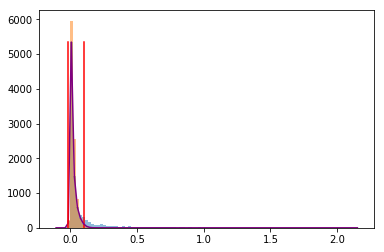

Got 9356 coords
After resolving overlaps, got 9356 seqlets
Across all tasks, the weakest transformed threshold used was: 0.519814596273292
MEMORY 3.323662336
9356 identified in total
Reducing weak_threshold_for_counting_sign to match weakest_transformed_thresh, from 0.8 to 0.519814596273292
2 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [8719, 637]
Idx to activities:  {0: '1', 1: '-1'}
MEMORY 3.323994112


In [13]:
import modisco
from collections import OrderedDict
import sys


def print_memory_use():
    import os
    import psutil
    process = psutil.Process(os.getpid())
    print("MEMORY",process.memory_info().rss/1000000000)

FRAC_SEQS_TO_USE = 0.02
NUM_SEQS_TO_USE = int(FRAC_SEQS_TO_USE*len(nanog_profile_wn_contribs))
print("num seqs to use:", NUM_SEQS_TO_USE)

task_names=["Nanog_profile_wn"]
contrib_scores={'Nanog_profile_wn':
                 nanog_profile_wn_contribs[:NUM_SEQS_TO_USE]}
hypothetical_contribs={'Nanog_profile_wn':
                       nanog_profile_wn_hypimp[:NUM_SEQS_TO_USE]}
one_hot=onehot_seq[:NUM_SEQS_TO_USE]
#null_tracks should either be a dictionary
# from task_name to 1d trakcs, or a callable
null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(
    num_to_samp=10000)
revcomp = True
plot_save_dir = "figures"

sliding_window_size = 21
flank_size = 10
histogram_bins = 100
percentiles_in_bandwidth = 10
overlap_portion = 0.5
min_metacluster_size = 100
min_metacluster_size_frac = 0.01
weak_threshold_for_counting_sign = 0.8
target_seqlet_fdr = 0.2
min_passing_windows_frac = 0.03
max_passing_windows_frac = 0.2
separate_pos_neg_thresholds = False
verbose = True
min_seqlets_per_task = None
other_tracks = []
#reducing from 50000 to 10000 for debugging purposes
max_seqlets_per_metacluster = 10000 #50000

overlap_resolver = modisco.core.SeqletsOverlapResolver(
    overlap_detector=modisco.core.CoordOverlapDetector(overlap_portion),
    seqlet_comparator=modisco.core.SeqletComparator(
       value_provider=
        modisco.value_provider.CoorScoreValueProvider()))

coord_producer = modisco.coordproducers.FixedWindowAroundChunks(
    sliding=sliding_window_size,
    flank=flank_size,
    suppress=(int(0.5*sliding_window_size)
              + flank_size),
    target_fdr=target_seqlet_fdr,
    min_passing_windows_frac=min_passing_windows_frac,
    max_passing_windows_frac=max_passing_windows_frac,
    separate_pos_neg_thresholds=separate_pos_neg_thresholds,
    max_seqlets_total=None,
    verbose=verbose,
    plot_save_dir=plot_save_dir) 

track_set = (modisco.tfmodisco_workflow.workflow.prep_track_set(
    task_names=task_names,
    contrib_scores=contrib_scores,
    hypothetical_contribs=hypothetical_contribs,
    one_hot=one_hot,
    revcomp=revcomp,
    other_tracks=other_tracks))

per_position_contrib_scores = OrderedDict([
    (x, [np.sum(s,axis=1) for s in contrib_scores[x]])
    for x in task_names])

multitask_seqlet_creation_results = modisco.core.MultiTaskSeqletCreator(
    coord_producer=coord_producer,
    overlap_resolver=overlap_resolver)(
        task_name_to_score_track=per_position_contrib_scores,
        null_tracks=null_per_pos_scores,
        track_set=track_set)

#find the weakest transformed threshold used across all tasks
weakest_transformed_thresh = (min(
    [min(x.tnt_results.transformed_pos_threshold,
         abs(x.tnt_results.transformed_neg_threshold))
         for x in (multitask_seqlet_creation_results.
                   task_name_to_coord_producer_results.values())]) -
    0.0001) #subtract 1e-4 to avoid weird numerical issues
print("Across all tasks, the weakest transformed threshold used"
      +" was: "+str(weakest_transformed_thresh))
print_memory_use()

all_seqlets = multitask_seqlet_creation_results.final_seqlets
print(str(len(all_seqlets))+" identified in total")
if (len(all_seqlets) < 100):
    print("WARNING: you found relatively few seqlets."
          +" Consider dropping target_seqlet_fdr") 

if int(min_metacluster_size_frac * len(all_seqlets)) > min_metacluster_size:
    print("min_metacluster_size_frac * len(seqlets) = {0} is more than min_metacluster_size={1}.".\
          format(int(min_metacluster_size_frac * len(all_seqlets)), min_metacluster_size))
    print("Using it as a new min_metacluster_size")
    min_metacluster_size = int(min_metacluster_size_frac * len(all_seqlets))

weak_threshold_for_counting_sign=0.8
if (weak_threshold_for_counting_sign is None):
    weak_threshold_for_counting_sign = weakest_transformed_thresh
else:
    weak_threshold_for_counting_sign =\
        weak_threshold_for_counting_sign
    
if (weak_threshold_for_counting_sign > weakest_transformed_thresh):
    print("Reducing weak_threshold_for_counting_sign to"
          +" match weakest_transformed_thresh, from "
          +str(weak_threshold_for_counting_sign)
          +" to "+str(weakest_transformed_thresh))
    weak_threshold_for_counting_sign = weakest_transformed_thresh

task_name_to_value_provider = OrderedDict([
    (task_name,
     modisco.value_provider.TransformCentralWindowValueProvider(
        track_name=task_name+"_contrib_scores",
        central_window=sliding_window_size,
        val_transformer= 
         coord_producer_results.tnt_results.val_transformer))
     for (task_name,coord_producer_results)
         in (multitask_seqlet_creation_results.
             task_name_to_coord_producer_results.items())])

min_metacluster_size=100
metaclusterer = modisco.metaclusterers.SignBasedPatternClustering(
                        min_cluster_size=min_metacluster_size,
                        task_name_to_value_provider=
                            task_name_to_value_provider,
                        task_names=task_names,
                        threshold_for_counting_sign=
                            weakest_transformed_thresh,
                        weak_threshold_for_counting_sign=
                            weak_threshold_for_counting_sign)

metaclustering_results = metaclusterer.fit_transform(all_seqlets)
metacluster_indices = np.array(
    metaclustering_results.metacluster_indices)
metacluster_idx_to_activity_pattern =\
    metaclustering_results.metacluster_idx_to_activity_pattern

num_metaclusters = max(metacluster_indices)+1
metacluster_sizes = [np.sum(metacluster_idx==metacluster_indices)
                      for metacluster_idx in range(num_metaclusters)]
if (verbose):
    print("Metacluster sizes: ",metacluster_sizes)
    print("Idx to activities: ",metacluster_idx_to_activity_pattern)
    print_memory_use()
    sys.stdout.flush()

In [14]:
metacluster_idx = 0
metacluster_size = metacluster_sizes[metacluster_idx]
print("On metacluster "+str(metacluster_idx))                       
if (max_seqlets_per_metacluster is None                        
    or max_seqlets_per_metacluster >= metacluster_size):       
    print("Metacluster size", metacluster_size)                     
else:                                                               
    print("Metacluster size {0} limited to {1}".format(             
            metacluster_size, max_seqlets_per_metacluster))    
sys.stdout.flush()                                                  
metacluster_activities = [                                          
    int(x) for x in                                                 
    metacluster_idx_to_activity_pattern[metacluster_idx].split(",")]
assert len(all_seqlets)==len(metacluster_indices)                       
metacluster_seqlets = [                                             
    x[0] for x in zip(all_seqlets, metacluster_indices)                 
    if x[1]==metacluster_idx][:max_seqlets_per_metacluster]    
relevant_task_names, relevant_task_signs =\
    zip(*[(x[0], x[1]) for x in                                     
        zip(task_names, metacluster_activities) if x[1] != 0])      
print('Relevant tasks: ', relevant_task_names)                      
print('Relevant signs: ', relevant_task_signs)                      
sys.stdout.flush()                                                  
if (len(relevant_task_names) == 0):                                 
    assert False, "This should not happen"                          
    sys.stdout.flush()                                              

onehot_track_name="sequence"
contrib_scores_track_names = [key+"_contrib_scores" for key in relevant_task_names]
hypothetical_contribs_track_names= [key+"_hypothetical_contribs" for key in relevant_task_names]                
track_signs=relevant_task_signs                              
other_comparison_track_names=[]



assert len(track_signs)==len(hypothetical_contribs_track_names)         
assert len(track_signs)==len(contrib_scores_track_names)                
                                                                                
seqlets_sorter = (lambda arr:                                           
                          sorted(arr,                                           
                                 key=lambda x:                                  
                                  -np.sum([np.sum(np.abs(x[track_name].fwd))    
                                     for track_name                             
                                     in contrib_scores_track_names])))

min_overlap_while_sliding = 0.7
pattern_comparison_settings =\
            modisco.affinitymat.core.PatternComparisonSettings(                         
                track_names=hypothetical_contribs_track_names                   
                            +contrib_scores_track_names                         
                            +other_comparison_track_names,                      
                track_transformer=modisco.affinitymat.L1Normalizer(),                   
                min_overlap=min_overlap_while_sliding)

#coarse_grained 1d embedder   
embedder_factory=(modisco.seqlet_embedding
                          .onehot_model_output.KerasModelOutputEmbedder
                          .get_factory(model_h5="embedding_model.h5"))
seqlets_to_1d_embedder = embedder_factory(                         
        onehot_track_name=onehot_track_name,                            
        toscore_track_names_and_signs=list(                             
        zip(hypothetical_contribs_track_names,                          
            [np.sign(x) for x in track_signs])))

#affinity matrix from embeddings                                        
coarse_affmat_computer =\
    modisco.affinitymat.core.AffmatFromSeqletEmbeddings(                        
        seqlets_to_1d_embedder=seqlets_to_1d_embedder,                  
        affinity_mat_from_1d=\
            modisco.affinitymat.core.NumpyCosineSimilarity(                     
                verbose=True,                                   
                gpu_batch_size=None),                                   
        verbose=True)                                           

affmat_from_seqlets_with_nn_pairs =\
    modisco.affinitymat.core.AffmatFromSeqletsWithNNpairs(                      
        pattern_comparison_settings=pattern_comparison_settings,        
        sim_metric_on_nn_pairs=\
            modisco.affinitymat.core.ParallelCpuCrossMetricOnNNpairs(           
                n_cores=10,                                   
                cross_metric_single_region=                             
                    modisco.affinitymat.core.CrossContinJaccardSingleRegion()))

seqlets = seqlets_sorter(metacluster_seqlets)
print("Computing coarse affmat", flush=True)
coarse_affmat = coarse_affmat_computer(seqlets)
print("Computing seqlet neighbors from coarse", flush=True)
seqlet_neighbors = (modisco.tfmodisco_workflow.seqlets_to_patterns
    .get_seqlet_neighbors_with_initcluster(       
        nearest_neighbors_to_compute=500,                         
        coarse_affmat=coarse_affmat,                                
        initclusters=None))


On metacluster 0
Metacluster size 8719
Relevant tasks:  ('Nanog_profile_wn',)
Relevant signs:  (1,)
Computing coarse affmat
Beginning embedding computation


/users/avanti/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Finished embedding computation in 15.31 s
Starting affinity matrix computations
Normalization computed in 0.14 s
Cosine similarity mat computed in 1.5 s
Normalization computed in 0.1 s
Cosine similarity mat computed in 1.38 s
Finished affinity matrix computations in 4.06 s
Computing seqlet neighbors from coarse
Computing fine-grained


In [16]:
dlembedding_coarse_affmat = coarse_affmat

In [15]:
#coarse_grained 1d embedder   
gkm_embedder_factory=(modisco.seqlet_embedding
                          .gapped_kmer.GappedKmerEmbedderFactory())
gkm_seqlets_to_1d_embedder = gkm_embedder_factory(                         
        onehot_track_name=onehot_track_name,                            
        toscore_track_names_and_signs=list(                             
        zip(hypothetical_contribs_track_names,                          
            [np.sign(x) for x in track_signs])))

#affinity matrix from embeddings                                        
gkm_coarse_affmat_computer =\
    modisco.affinitymat.core.AffmatFromSeqletEmbeddings(                        
        seqlets_to_1d_embedder=gkm_seqlets_to_1d_embedder,                  
        affinity_mat_from_1d=\
            modisco.affinitymat.core.NumpyCosineSimilarity(                     
                verbose=True,                                   
                gpu_batch_size=None),                                   
        verbose=True) 
gkm_coarse_affmat = gkm_coarse_affmat_computer(seqlets)

Beginning embedding computation
Computing embeddings
Finished embedding computation in 443.99 s
Starting affinity matrix computations
Normalization computed in 15.71 s
Cosine similarity mat computed in 123.28 s
Normalization computed in 20.21 s
Cosine similarity mat computed in 122.79 s
Finished affinity matrix computations in 247.79 s


In [121]:

#let's build an advanced gapped kmer embedder that scales up to 20

def recursively_get_gappedkmersandimp(posbaseimptuples, max_k, max_gap, max_len):
    #preceding_posbaseimptuples: [(0-based-position, base, imp)...]
    #A gapped kmer representation: [(gapbefore, base)...]
    #Gapped kmers and imp: [(gapped_kmer_representation, start_pos, end_pos, totalimp)]
    if (len(posbaseimptuples)==0):
        return []
    else:
        lastbasepos, lastbase, lastbaseimp = posbaseimptuples[-1]
        preceding_gappedkmersandimp_list =\
            recursively_get_gappedkmersandimp(
                posbaseimptuples[:-1], max_k=max_k, max_gap=max_gap, max_len=max_len)
        new_gappedkmersandimp_list = []
        new_gappedkmersandimp_list.append( ([(0, lastbase)], lastbasepos, lastbasepos+1, lastbaseimp) )
        for (gappedkmer_rep, startpos, endpos, totalimp) in preceding_gappedkmersandimp_list:
            new_gappedkmersandimp_list.append( (gappedkmer_rep, startpos, endpos, totalimp) )
            if ((lastbasepos-startpos)+1 < max_len
                and (lastbasepos-endpos)+1 <= max_gap
                and len(gappedkmer_rep) < max_k):
                new_gappedkmersandimp_list.append( (gappedkmer_rep+[(lastbasepos-endpos, lastbase)],
                                          startpos, lastbasepos+1, totalimp+lastbaseimp) )
        return new_gappedkmersandimp_list    
    

class AdvancedGappedKmerEmbedding(object):
    
    def __init__(self, gapped_kmer_to_totalseqimp):
        self.gapped_kmer_to_totalseqimp = gapped_kmer_to_totalseqimp
        
    @classmethod
    def from_contribs(cls, contrib_scores, topn, min_k, max_k, max_gap, max_len):
        #get the top n positiosn
        per_pos_imp = np.sum(contrib_scores, axis=-1)
        per_pos_bases = np.argmax(contrib_scores, axis=-1)
        #get the top n positions
        topn_pos = np.argsort(-per_pos_imp)[:topn]
        #prepare 'posbaseimp tuples':
        posbaseimptuples = sorted([ (pos, per_pos_bases[pos], per_pos_imp[pos])
                                     for pos in topn_pos ], key=lambda x:x[0])
        gappedkmersandimp = recursively_get_gappedkmersandimp(
            posbaseimptuples, max_k=max_k, max_gap=max_gap, max_len=max_len)
        
        #condense this by total imp on gapped gkmers across sequence
        gapped_kmer_to_totalseqimp = {}
        for gapped_kmer_rep, startpos, endpos, gapped_kmer_imp in gappedkmersandimp:
            assert gapped_kmer_rep[0][0]==0 #no superfluous pre-padding
            gapped_kmer_rep = tuple(gapped_kmer_rep)
            if (len(gapped_kmer_rep) >= min_k):
                gapped_kmer_to_totalseqimp[gapped_kmer_rep] = (
                    gapped_kmer_to_totalseqimp.get(gapped_kmer_rep, 0) + gapped_kmer_imp)
        return cls(gapped_kmer_to_totalseqimp=gapped_kmer_to_totalseqimp)
        

#get advanced embedding for each seqlet
advanced_gappedkmer_embeddings_fwd = []
advanced_gappedkmer_embeddings_rev = []
SEQLETS_SUBSET = 100
for i,seqlet in enumerate(seqlets[:SEQLETS_SUBSET]):
    if (i%10==0):
        print("Done",i)
    advanced_gappedkmer_embeddings_fwd.append(
        AdvancedGappedKmerEmbedding.from_contribs(
            seqlet["Nanog_profile_wn_contrib_scores"].fwd,
            topn=20, min_k=4, max_k=6, max_gap=5, max_len=15))
    advanced_gappedkmer_embeddings_rev.append(
        AdvancedGappedKmerEmbedding.from_contribs(
            seqlet["Nanog_profile_wn_contrib_scores"].rev,
            topn=20, min_k=4, max_k=6, max_gap=5, max_len=15))

Done 0
Done 10
Done 20
Done 30
Done 40
Done 50
Done 60
Done 70
Done 80
Done 90


182 6026 1116.0


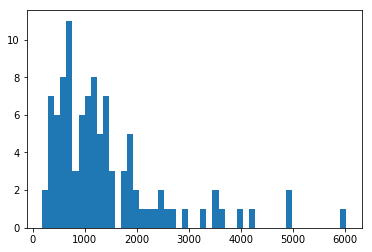

In [122]:
#histogram of embedding sizes
from matplotlib import pyplot as plt
embedding_sizes = [len(x.gapped_kmer_to_totalseqimp) for x in advanced_gappedkmer_embeddings_fwd]
print(min(embedding_sizes), max(embedding_sizes), np.median(embedding_sizes))
plt.hist(embedding_sizes, bins=50)
plt.show()
print()

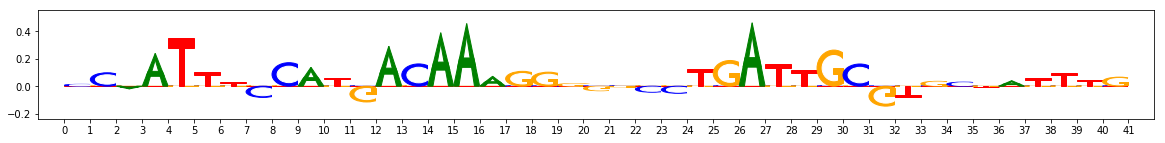

['TNNNNANNNNAA', 'TNNNCNNNANAA', 'CNNNANAA', 'ACAA', 'TNNNNANNANAA', 'ANNANAA', 'TNNNCNNNANNA', 'ATNNNCNNNANAA', 'ATNNNNANNNNAA', 'ANAANG', 'ATNNNNANNANAA', 'ANAANNG', 'ANNNNCNNNANAA', 'TNNNNANNANNA', 'TNNNCNNNNCAA', 'TNNNCNNNACAA', 'ATNNNCNNNANNA', 'TNNNCANNNNAA', 'TNNNCNNNANA', 'TNNNCANNANAA', 'TNNNNANNNCAA', 'TNNNNANNACAA', 'CNNNNCAA', 'ATNNNNANNANNA', 'ATNNNCNNNNCAA', 'CNNNACAA', 'TNNNCNNNANAANG', 'TTNNCNNNANAA', 'TNNNNANNANA', 'ATNNNCANNNNAA', 'ANNNNCNNNANNA', 'CANNANAA', 'ATNNNNANNNCAA', 'CANNNNAA', 'TNNNNANNANAANG', 'TTNNNANNANAA', 'TNNNNANNNNAANG', 'ATNNNCNNNANA', 'ANNACAA', 'TTNNNANNNNAA', 'ANNNCAA', 'TNNNCNNNACNA', 'ANNNNCNNNACAA', 'TNNNCNNNNCNA', 'ANNNNCNNNNCAA', 'CNNNANAANG', 'TNNCNNNANAA', 'CNNNANAANNG', 'ACAANG', 'ATNNNNANNANA', 'TNNNCANNANNA', 'ANNNNCANNANAA', 'ACAANNG', 'ATTNNNANNNNAA', 'TNNNNANNACNA', 'CAANG', 'ANNNNCANNNNAA', 'ATNNNNANNNNA', 'ATNNNCNNNACNA', 'CAANNG', 'TNNNCANNNCAA', 'ANNANAANG', 'TNNNANNANAA', 'TNNNNANNNCNA', 'ANTNNCNNNANAA', 'ANNANAANNG', 'ATNNNCNNN

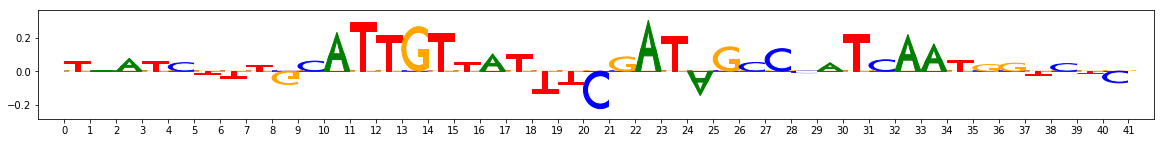

['ATNNNNAT', 'ATNGT', 'ATTG', 'TTGT', 'ATTGT', 'ATTNT', 'TNGNNNTNNNNA', 'ATNGNNNTNNNNA', 'TNGTNNTNNNNA', 'ATNGTNNTNNNNA', 'TTGNNNTNNNNA', 'ATTGNNNTNNNNA', 'TNGNNNTNNNNAT', 'TTGTNNTNNNNA', 'ANTGT', 'ATNGNNNTNNNNAT', 'TNGTNNTNNNNAT', 'TNNTNNTNNNNA', 'ATNNTNNTNNNNA', 'TTGNNNTNNNNAT', 'ATTNNNNTNNNNA', 'ATTNTNNTNNNNA', 'TTNNNNTNNNNA', 'TTNTNNTNNNNA', 'ATNNTNNTNNNNAT', 'TNNTNNTNNNNAT', 'ATTNNNNTNNNNAT', 'ANNGTNNTNNNNA', 'ANNGNNNTNNNNA', 'TTNTNNTNNNNAT', 'ATNGTNA', 'TTNNNNTNNNNAT', 'ATNGNNA', 'GTNNTNNNNA', 'ATNGTNNT', 'ANTGTNNTNNNNA', 'ATNGNNNT', 'ANTGNNNTNNNNA', 'TNGTNA', 'ATTGTNA', 'ATTGTNNT', 'ANNGTNNTNNNNAT', 'ATTGNNA', 'TGTNNTNNNNA', 'TNGTNNT', 'ANNGNNNNTNA', 'ATTGNNNT', 'ANNGNNNTNNNNAT', 'TTGTNA', 'TGNNNTNNNNA', 'TTGTNNT', 'GTNNTNNNNAT', 'ANTGNNNTNNNNAT', 'TTGNNA', 'TGTNNTNNNNAT', 'TTGNNNT', 'GNNNTNNNNAT', 'ANNNNCNNTNA', 'ATNGNNNNT', 'ATNGNNNNTNA', 'TGNNNTNNNNAT', 'ATNNNCNNTNA', 'ATNGNNATNNNNA', 'ATNNNCNNT', 'ATNNNCNNNNA', 'TNGTNATNNNNA', 'CATNGT', 'CATTGT', 'ANNNTNNTNNNNA', 'ANTNTNNTNN

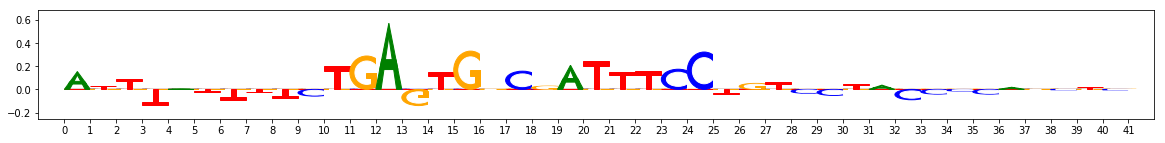

['GANNNNCNNT', 'GANTNNC', 'ANTNNCNNT', 'GANTNNCNNT', 'ANNGNNNNTNNNC', 'GANNGNNNNT', 'ANNGNNNANNNNC', 'GANNGNNNNTNNNC', 'GNNTNNCNNT', 'GANNGNNNA', 'TGANNG', 'GANNGNNNANNNNC', 'ANNGNNNAT', 'TNANNGNNNNT', 'GANNGNC', 'ANNGNNNATNNNC', 'GANTG', 'ANNGNNNNTNNC', 'GANNGNNNAT', 'ANNGNNNNTNNCC', 'TGANNGNNNNT', 'TNANNGNNNA', 'GANNGNNNATNNNC', 'ANNGNCNNT', 'ANNGNNNNTNT', 'ANNGNCNNTNNNC', 'ANNGNNNNTNTNC', 'ANNGNNNNTT', 'ANNNNCNNTNNNC', 'ANNGNNNNTTNNC', 'ANTGNNNNT', 'ANTGNNNNTNNNC', 'GANNGNNNNTNNCC', 'GANNGNNNNTNNC', 'ANNGNNNANNNCC', 'ANNGNNNANNNC', 'TGANNGNNNA', 'GANNGNCNNTNNNC', 'GANNGNNNNTNTNC', 'GANNGNCNNT', 'GANNGNNNNTNT', 'GANNGNNNNTTNNC', 'GANTGNNNNTNNNC', 'ANNGNCNANNNNC', 'GANNGNNNNTT', 'ANNGNNNANNTNC', 'GANNNNCNNTNNNC', 'GANTGNNNNT', 'ANNGNCNA', 'ANNGNNNANTNNC', 'ANNGNNNANNT', 'ANTGNNNANNNNC', 'GANNGNNNANNNCC', 'TNANNGNC', 'ANNGNNNANT', 'ANNNNCNANNNNC', 'GANNGNNNANNNC', 'ANTGNNNA', 'GANNGNCNANNNNC', 'TNANTG', 'GANNGNNNANNTNC', 'TNANNGNNNAT', 'ANTNNNNANNNNC', 'GANNGNNNANTNNC', 'GANTGNNNANNNNC

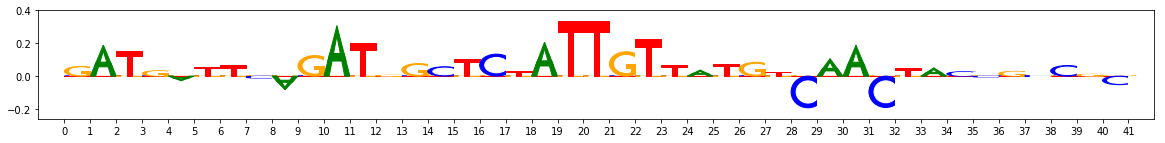

['ATNNNTNNNNT', 'ATNGNT', 'GNTNNNTNNNT', 'ATNNNTNNG', 'ATTNT', 'ANNNNTNNNTT', 'ATNNNNCNNTT', 'ANNNNTNNNTTNT', 'TTGT', 'ANNNNTNNATT', 'CNNTTNT', 'ATNNNTNNNTT', 'ATTG', 'ATNNNNCNNTTNT', 'ATNNNNCNATT', 'CNATT', 'ANNNNTNNATTNT', 'ANNGNNNNATT', 'ATNNNTNNNTTNT', 'TNNNNCNNTT', 'ATTGT', 'TNNNTTNT', 'ATNNNTNNATT', 'ANNGNNNNATTNT', 'CNATTNT', 'ANNNNTNNNTTG', 'TNNNNCNNTTNT', 'TNNATT', 'TTNTNNNG', 'ATNNNNCNNT', 'ATNNNNCNNNT', 'TNNNTNNNTT', 'ANNNNTNNNTNNT', 'ATNGNNNNATT', 'ANNNNTCNNTT', 'ATNNNNCNNTTG', 'ANNNNTNNNNTNT', 'ANNNNTNNNTTGT', 'TTNTNNT', 'TNNNNCNATT', 'GANNNNTNNNTT', 'TNNATTNT', 'TTNTT', 'ATNNNNCNNTNNT', 'ANNNNTCNNTTNT', 'ATNNNNCNNNTNT', 'TNNNTNNNTTNT', 'ANNNNTNNATTG', 'GATNNNNCNNTT', 'TNNNNCNATTNT', 'GANNNNTNNNTTNT', 'ANNNNTNNAT', 'ATNNNTNNNTTG', 'ANNNNTNNANT', 'GNNNNATT', 'CNNTTG', 'ATTNNNNT', 'ANNGNNCNNTT', 'ATTNTNNNG', 'ANNNNTCNATT', 'ATNNNTNNNT', 'ATNNNNCNAT', 'ATTNNT', 'ATNNNNCNANT', 'TNNNTNNATT', 'ANNNNTNNATNNT', 'ATNNNTCNNTT', 'ANNNNTNNANTNT', 'GNNNNATTNT', 'GANNNNTNNATT', 'CNNTTGT

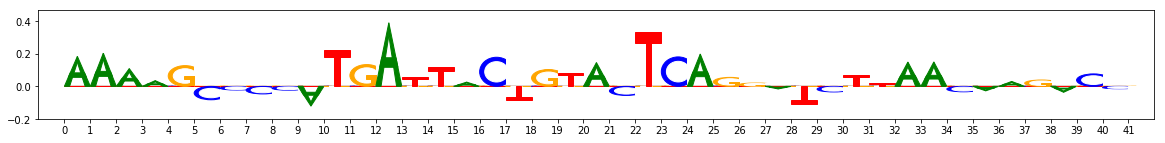

['ANNNCNNNANT', 'TNANNNCNNNANT', 'ANNNCNGNNNT', 'ANNNCNNNANTNA', 'ANNNCNNTNNT', 'ANNNCNNNANTC', 'TNANNNCNGNNNT', 'TNANNNCNNNANTC', 'TNANNNCNNTNNT', 'ANNNCNGNNNTNA', 'ANNNCNNNANTCA', 'ANNNCNGNNNTC', 'ANNNCNNTNNTNA', 'GANNNCNNNANT', 'ANTNNNGNNNT', 'TNANNNCNGNNNTC', 'TNANNNCNNNA', 'TGANNNCNNNANT', 'TNANTNNNGNNNT', 'ANTNCNNNANT', 'ANNNCNNTNNTC', 'TGANNNC', 'TNANTNCNNNANT', 'TNANNNCNNTNNTC', 'ANTNNNNTNNT', 'ANNNCNGNNNTCA', 'ANNNCNGNANT', 'GANNNCNNNANTNA', 'TNANTNNNNTNNT', 'TNANNNCNGNANT', 'ANTNNNGNNNTNA', 'ANNNCNNNANNNA', 'GANNNCNGNNNT', 'TNANTNC', 'ANTNCNNNANTNA', 'ANNNCNNTNNTCA', 'GANNNCNNNANTC', 'TGANNNCNGNNNT', 'ANNNCNNTANT', 'TNANNNCNNTANT', 'ANTNNNGNNNTC', 'ANNNCNGNANTNA', 'TNANTNNNGNNNTC', 'ANTNCNGNNNT', 'ANTNNNNTNNTNA', 'ANTNCNNNANTC', 'TNANTNCNGNNNT', 'ANNNCNNNANNC', 'TNANNNCNG', 'TNANNNCNNNANNC', 'GANNNCNNTNNT', 'TGANNNCNNTNNT', 'GANNNCNGNNNTNA', 'ANNNCNGNANTC', 'ANNNCNNTANTNA', 'TNANTNNNNTNNTC', 'ANTNNNNTNNTC', 'TNANTNCNNTNNT', 'TNATNNCNNNANT', 'TNATNNNNGNNNT', 'ANTNNNGNNNTCA', '

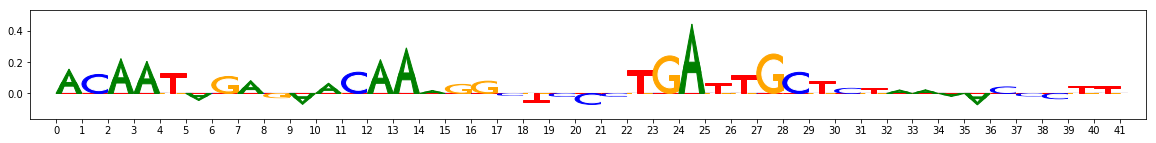

['ACAA', 'CAANNG', 'ANAANNG', 'ACAANNG', 'ACNANNG', 'ACANNNG', 'TGANNG', 'GANNGC', 'GANTG', 'GANNGNT', 'GATNG', 'TNANNGC', 'TGANNGC', 'TGANNNC', 'TNANTG', 'TGANTG', 'GANTGC', 'TGANT', 'ANTGC', 'GANTNC', 'TGANNGNT', 'TNANNGNT', 'TGATNG', 'GANNGCT', 'TGANNNNT', 'TNATNG', 'ANNGCT', 'GATNGC', 'GANTGNT', 'TGAT', 'GANNNCT', 'ATNGC', 'GATTG', 'ANTGNT', 'TGANTGC', 'GATNNC', 'GANTNNT', 'ATTG', 'TNANTGC', 'GATT', 'TGANTNC', 'GATNGNT', 'TGANNGCT', 'TGATNGC', 'TGANTGNT', 'TNANNGCT', 'TGATTG', 'GANTGCT', 'TNANTNC', 'ATNGNT', 'TGANNNCT', 'GATTGC', 'TNATNGC', 'TNANTGNT', 'GATNNNT', 'TGATNNC', 'TGANTNNT', 'TNATTG', 'ANTGCT', 'TGATNGNT', 'AANNNANNNNAA', 'TGATT', 'GANTNCT', 'ATTGC', 'ANNNNANNNNAA', 'GATNGCT', 'TNANNNCT', 'GATTNC', 'GATTGNT', 'ANNNANNNNAA', 'TNATNNC', 'TNATNGNT', 'TNANTNNT', 'AANNGNNNNCAA', 'TNANTGCT', 'ANAANNNANNNNAA', 'TGATNNNT', 'ATNGCT', 'ANNNGNNNNCAA', 'TNATT', 'ANTNCT', 'TGANTNCT', 'TNATTGC', 'TGNNNGC', 'ANANNNNANNNNAA', 'GATNNCT', 'AANNGNNNNCNA', 'AANNNANNNCAA', 'ATTGNT', 'TGATTNC

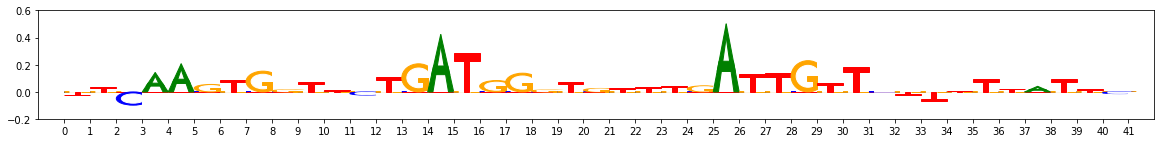

['ATNGNT', 'ANTGNT', 'GATNG', 'TNNTNNTG', 'TGAT', 'ATTG', 'ANNGNTNNNNT', 'GATG', 'GATNNNT', 'ANNNNTNNNNAT', 'TNNNGAT', 'ANNGTT', 'GNNNNTNAT', 'TNATNG', 'ATTNNT', 'ANNNNTNNNGAT', 'ATTGNT', 'ANNGNNNNTNAT', 'GNNNNTGAT', 'ANTGT', 'GNTNNNNAT', 'TGATNG', 'ATNGT', 'ATGG', 'ANNGNNNNTGAT', 'TNNNNATNG', 'ANTGNTNNNNT', 'ANTNNTNNNNT', 'ANNGNTNNNNAT', 'GNTNNNGAT', 'ATNGNTNNNNT', 'ATNNNTNNNNT', 'GATGG', 'ANNNNTNNNGA', 'TNATG', 'AANNNNTNNNNAT', 'GATNGNT', 'ANNNNTNNNNATNG', 'TNNNGATNG', 'ANNGNTNNNGAT', 'TNATNNNT', 'ANNGNNNNTNA', 'GNNNNTGA', 'ANTGTT', 'ANNNGNNNNTNAT', 'TNNTNAT', 'AANNNNTNNNGAT', 'TGATG', 'ATNGTT', 'GNNNNTNATNG', 'ANNNNTNNNGATNG', 'ANTNTT', 'AANNGNNNNTNAT', 'ANNNGNNNNTGAT', 'ATNNTT', 'TGATNNNT', 'ANNGNNNNTGA', 'ANNNNTNNTNAT', 'TGANNG', 'TNNTGAT', 'ANNGNNNNTNATNG', 'GNNNNTGATNG', 'ANNGNTNNNNTNNT', 'ANNNNTNNTGAT', 'TNNTNNNNAT', 'ANNNNTNNNNTNNT', 'ATGNNT', 'TNNNNATG', 'ANTNNTNNNNAT', 'ANNNGNTNNNNAT', 'TNNTNNNGAT', 'GATGNNT', 'ANNNNTNNNNATG', 'TNNNGATG', 'GNTNNNNATNG', 'ATTGT', 'ANNGTTNNNNT

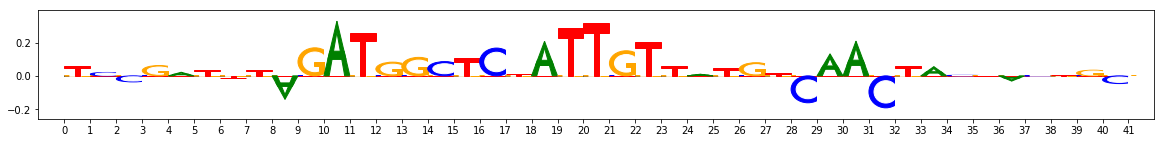

['ATNGNT', 'GNTNNNTNNNT', 'ATNNNNCNNTT', 'ATNNNNCNNNT', 'ATNNNNCNATT', 'ATNNNNCNNTTNT', 'ATNNNNCNNT', 'ANNNNTNNNTT', 'ATNNNTNNNTT', 'TNNNNCNNTT', 'ATNNNNCNANT', 'ATNNCNNNNTT', 'ATNNNNCNNNTNT', 'ANNNCNNNNTT', 'GATNNNNCNNTT', 'ATTNT', 'ATNNNTNNNNT', 'ATNGNNNNATT', 'ATNNNNCNNTTG', 'ATNNNTNNATT', 'ATNNNTNNNTTNT', 'ANNGNNNNATT', 'ATNNNNCNAT', 'ANNNNTNNATT', 'ATNNNNCNNTNNT', 'ANNNNTNNNTTNT', 'GATNNNNCNNNT', 'TNNNNCNATT', 'ATNNCNNNATT', 'ATNNNNCNANTNT', 'TNNNNCNNTTNT', 'ATNNCNNNNTTNT', 'ANNNCNNNATT', 'ATNGNNCNNTT', 'ANNNCNNNNTTNT', 'ATNGNNNNANT', 'ATNNNTNNNT', 'CNATT', 'ATNNNNCNNNTG', 'CNNTTNT', 'GATNNNTNNNTT', 'ATNNNTCNNTT', 'ATNNNTNNANT', 'ATNNNTNNNNTNT', 'ANNGNNNNATTNT', 'TNNNTNNNTT', 'ANNGNNCNNTT', 'ATNNNNCNATNNT', 'ANNNNTNNATTNT', 'GATNNNNCNNT', 'ATNNNTNNNTTG', 'GANNNNTNNNTT', 'GATNNNNCNANT', 'ANNGNNNNANT', 'GATNNCNNNNTT', 'GATNNNNCNNNTNT', 'ANNNNTCNNTT', 'ATNNCNCNNTT', 'ATTG', 'TNNNNCNATTNT', 'TTGT', 'ATGNNNCNNTT', 'ATNNNNCNA', 'GNTNNNNCNNTT', 'ATNNCNNNANT', 'ATNNCNNNNT', 'ANNNNTNNANT',

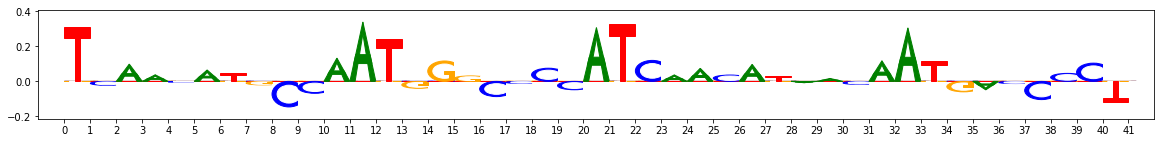

['TNNNNANNNNAA', 'TNNNNANNNNAAT', 'TNNANANNNNAA', 'TNNANANNNNAAT', 'ANNNNAAT', 'TNNNNANNNNANT', 'ANANNNNAAT', 'TNNANANNNNANT', 'ANANNNNAA', 'TNNANANNNNA', 'ATNGNNNCNAT', 'ANNGNNNCNAT', 'ATNNNNANNNNAA', 'ANANNNNANT', 'ATNGNNNCNNT', 'AANNGNNNCNAT', 'ATNGNNNCNA', 'ANNGNNNCNNT', 'ANNGNNNCNATC', 'TNGNNNCNAT', 'ATCNNNA', 'ATCNNNANNNNAA', 'ATNNNNANNNNA', 'ATNNNNANNNNAAT', 'ANNGNNNCNA', 'TNANNNTNNNNAT', 'AATNG', 'CNATC', 'ATCNA', 'ANNGNNNCNATNNA', 'GNNNCNAT', 'AATNGNNNCNNT', 'ATNNANANNNNAA', 'ATNGNNNCNNTC', 'AATNGNNNCNA', 'CNATNNNNA', 'ATNNANA', 'TNNNNATNNNNAT', 'ATNGNNNCNANC', 'ANTNGNNNCNAT', 'TNANNNTNNNNA', 'TNANNANNNNAAT', 'AANNGNNNCNNT', 'TNGNNNCNATC', 'CNATNNA', 'TNNANNTNNNNAT', 'ATNGNNNCNNTNNA', 'TNANNNTNNNAAT', 'ANNGNNNCNNTC', 'AANNGNNNCNA', 'ATCNNNANNNNA', 'ATNGNNNC', 'TCNNNANNNNAA', 'ATNNNNANNNNANT', 'ATNGNNNCNANNNA', 'ANNGNNNCNANC', 'ANNNGNNNCNAT', 'TNNNNATNNNNA', 'TNNNAAT', 'TNGNNNCNATNNA', 'TNNNNATNNNAAT', 'TNGNNNCNNT', 'TNANNANNNNAA', 'ANCNNNANNNNAA', 'GNNNCNATC', 'ANNGNNNCNNTNNA'

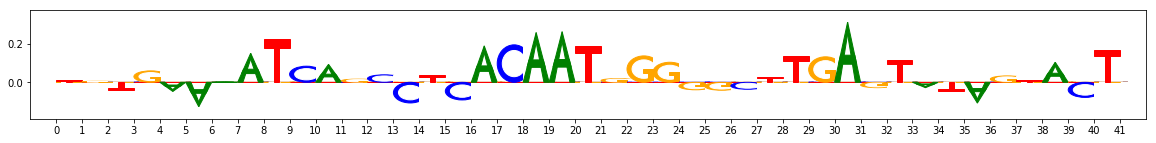

['ACAA', 'CAAT', 'ANAAT', 'ACAAT', 'AANNNGNNNNTNA', 'CAANNG', 'ANAANNG', 'CAANNNGNNNNTNA', 'AATNG', 'AATNNGNNNNTNA', 'ACAANNG', 'ACNAT', 'CAATNG', 'ACANT', 'ANAATNG', 'CAANNNG', 'ACAATNG', 'ANNNGNNNNTNA', 'ANAANNNG', 'AATNNG', 'ANNNNGNNNNTNA', 'CNANNNGNNNNTNA', 'AANNGGNNNNTNA', 'ACAANNNG', 'CAATNNG', 'CANNNNGNNNNTNA', 'AANNNGNNNNTGA', 'ATNNGNNNNTNA', 'ANAATNNG', 'ANTNNGNNNNTNA', 'CNATNNGNNNNTNA', 'ACAATNNG', 'CANTNNGNNNNTNA', 'TNNNCNNNNCAA', 'ACNANNG', 'CNATNG', 'TNNNCNNNANAA', 'TNNNCNNNACAA', 'ACANNNG', 'TNNNCNNNNCAAT', 'CANTNG', 'ACNATNG', 'ANNATNG', 'TNNNCNNNANAAT', 'ACANTNG', 'ANANTNG', 'CAANNGG', 'CAANNNGNNNNT', 'CNANNGGNNNNTNA', 'ACAANNGG', 'ACAANNNGNNNNT', 'CAATNGG', 'AANNGG', 'ANNGGNNNNTNA', 'CAATNNGNNNNT', 'CANNNGGNNNNTNA', 'CNANNNGNNNNTGA', 'AANNNGNNNNT', 'ANAANNGG', 'ANAANNNGNNNNT', 'ATNGGNNNNTNA', 'AATNGG', 'ANAATNGG', 'AATNNGNNNNT', 'CANNNNGNNNNTGA', 'ANNNGGNNNNTNA', 'ANAATNNGNNNNT', 'ANNNGNNNNTGA', 'ANTNGGNNNNTNA', 'ATNNGNNNNTGA', 'CNNNACAA', 'ANNNNGNNNNTGA', 'CNNNNCAA', 

In [130]:
from modisco.visualization import viz_sequence

letters = "ACGT"

def gapnletteridx_to_string(gap,letteridx):
    return "".join(["N" for i in range(gap)]+[letters[letteridx]])

def get_list_imp_gappedkmers(advanced_gapped):
    return sorted([("".join([gapnletteridx_to_string(*x) for x in key]), value/len(key) )
                       for key,value in advanced_gapped.gapped_kmer_to_totalseqimp.items()],
                   key=lambda x: -x[1] )

for idx_to_viz in range(10):
    viz_sequence.plot_weights(seqlets[idx_to_viz]["Nanog_profile_wn_contrib_scores"].fwd)
    print([x[0] for x in get_list_imp_gappedkmers(advanced_gappedkmer_embeddings_fwd[idx_to_viz])[:100]] )

In [131]:
def compute_cosine_sim(advanced_gapped_1, advanced_gapped_2):
    sum_squares_1 = sum([x**2 for x in advanced_gapped_1.gapped_kmer_to_totalseqimp.values()])
    sum_squares_2 = sum([x**2 for x in advanced_gapped_2.gapped_kmer_to_totalseqimp.values()])
    dotprod = 0
    for key in advanced_gapped_1.gapped_kmer_to_totalseqimp:
        if key in advanced_gapped_2.gapped_kmer_to_totalseqimp:
            dotprod += advanced_gapped_1.gapped_kmer_to_totalseqimp[key]*advanced_gapped_2.gapped_kmer_to_totalseqimp[key]
    return dotprod/((sum_squares_1*sum_squares_2)**0.5)
    
advanced_gapped_cosine_sims = np.zeros(
    (len(advanced_gappedkmer_embeddings_fwd), len(advanced_gappedkmer_embeddings_fwd)))
for i in range(len(advanced_gappedkmer_embeddings_fwd)):
    if (i%10==0):
        print(i)
    for j in range(i, len(advanced_gappedkmer_embeddings_fwd)):
        cosine_sim_fwd = compute_cosine_sim(advanced_gappedkmer_embeddings_fwd[i],
                                            advanced_gappedkmer_embeddings_fwd[j])
        cosine_sim_rev = compute_cosine_sim(advanced_gappedkmer_embeddings_fwd[i],
                                            advanced_gappedkmer_embeddings_rev[j])
        cosine_sim = max(cosine_sim_fwd, cosine_sim_rev)
        advanced_gapped_cosine_sims[i,j] = cosine_sim
        advanced_gapped_cosine_sims[j,i] = cosine_sim

0
10
20
30
40
50
60
70
80
90


In [144]:
#compare nearest neighbors
subset_advanced_gapped_coarse_affmat = advanced_gapped_cosine_sims
subset_gkm_coarse_affmat = gkm_coarse_affmat[:SEQLETS_SUBSET][:,:SEQLETS_SUBSET]
subset_dlembedding_coarse_affmat = dlembedding_coarse_affmat[:SEQLETS_SUBSET][:,:SEQLETS_SUBSET]

print("Computing fine-grained", flush=True)
seqlet_neighbors = (modisco.tfmodisco_workflow.seqlets_to_patterns
    .get_seqlet_neighbors_with_initcluster(       
        nearest_neighbors_to_compute=500,                         
        coarse_affmat=subset_gkm_coarse_affmat,                                
        initclusters=None))
affmat_from_seqlets_with_nn_pairs_argmax =\
    modisco.affinitymat.core.AffmatFromSeqletsWithNNpairs(
        pattern_comparison_settings=pattern_comparison_settings,
        sim_metric_on_nn_pairs=\
            modisco.affinitymat.core.ParallelCpuCrossMetricOnNNpairs(
                n_cores=10,
                cross_metric_single_region=
                    modisco.affinitymat.core.CrossContinJaccardSingleRegionWithArgmax()))
sparse_nn_affmat_withargmax = affmat_from_seqlets_with_nn_pairs_argmax(
    seqlet_neighbors=seqlet_neighbors,
    seqlets=seqlets[:len(subset_gkm_coarse_affmat)],
    return_sparse=True)

Computing fine-grained
Launching nearest neighbors affmat calculation job
MEMORY 6.591307776
Parallel runs completed
MEMORY 6.615568384
Job completed in: 1.15 s
MEMORY 6.615568384
Launching nearest neighbors affmat calculation job
MEMORY 6.615568384
Parallel runs completed
MEMORY 6.62206464
Job completed in: 0.72 s
MEMORY 6.62206464


Correlations


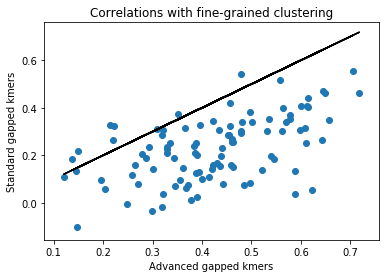

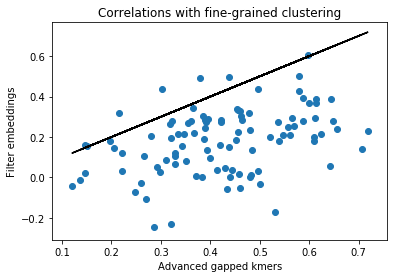

In [153]:
#Get correlations with fine-grained

import scipy


def reconstitute_dense_affmat(sparse_affmat_withargmax, seqlet_neighbors):
    to_return = np.zeros((len(seqlet_neighbors), len(seqlet_neighbors)))
    for row_idx, (neighbors, affinitieswithargmax) in enumerate(zip(seqlet_neighbors, sparse_affmat_withargmax)):
        affinities = affinitieswithargmax[:,0]
        for col_idx, val in zip(neighbors, affinities):
            to_return[row_idx, col_idx] = val
    return to_return


def get_correlations(main_affmat, other_affmat):
    correlations = []
    for main_affmat_row, other_affmat_row\
        in zip(main_affmat, other_affmat):
        #compare correlation on the nonzero rows
        to_compare_mask = np.abs(main_affmat_row) > 0
        corr = scipy.stats.spearmanr(
                main_affmat_row[to_compare_mask],
                other_affmat_row[to_compare_mask])
        correlations.append(corr.correlation)
    correlations = np.array(correlations)
    return correlations


dense_finegrained_nn_affmat = reconstitute_dense_affmat(
                    sparse_affmat_withargmax=sparse_nn_affmat_withargmax,
                    seqlet_neighbors=seqlet_neighbors[:len(sparse_nn_affmat_withargmax)])

correlations_advanced_gapped = get_correlations(main_affmat=dense_finegrained_nn_affmat,
                                             other_affmat=subset_advanced_gapped_coarse_affmat)
correlations_gkm = get_correlations(main_affmat=dense_finegrained_nn_affmat,
                                             other_affmat=subset_gkm_coarse_affmat)
correlations_dlembedding = get_correlations(main_affmat=dense_finegrained_nn_affmat,
                                             other_affmat=subset_dlembedding_coarse_affmat)

print("Correlations")
plt.scatter(correlations_advanced_gapped, correlations_gkm)
plt.plot(correlations_advanced_gapped, correlations_advanced_gapped, color="black")
plt.title("Correlations with fine-grained clustering")
plt.xlabel("Advanced gapped kmers")
plt.ylabel("Standard gapped kmers")
plt.show()

plt.scatter(correlations_advanced_gapped, correlations_dlembedding)
plt.plot(correlations_advanced_gapped, correlations_advanced_gapped, color="black")
plt.title("Correlations with fine-grained clustering")
plt.xlabel("Advanced gapped kmers")
plt.ylabel("Filter embeddings")
plt.show()


###########################
Seqlet idx 10
METHODNAME advanced_gapped_coarse_affmat ----------------------
original seqlet:


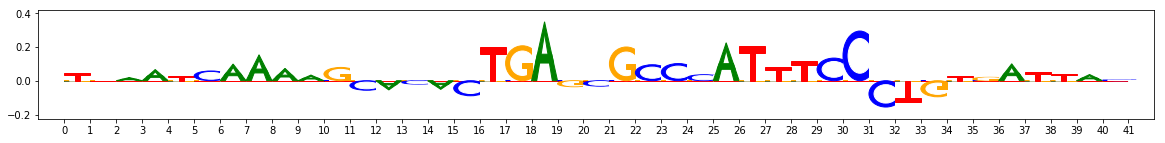

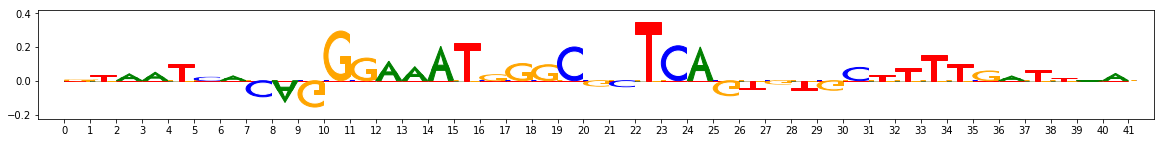

Neighbor rank 1 seqletidx 42


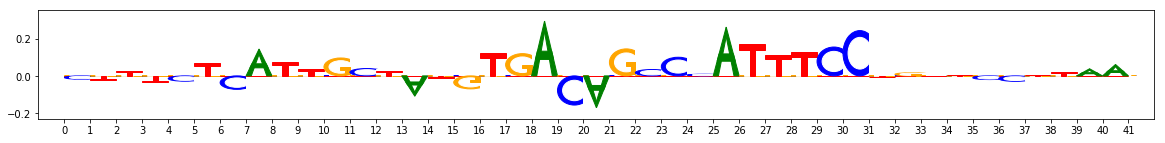

Neighbor rank 2 seqletidx 2


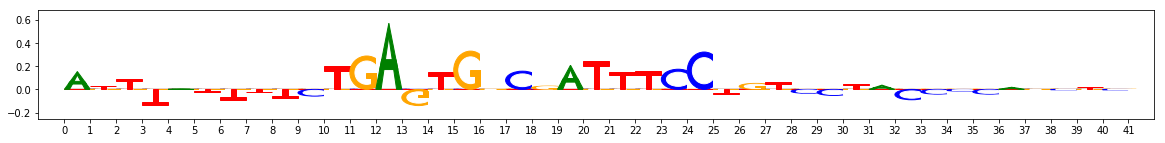

Neighbor rank 3 seqletidx 86


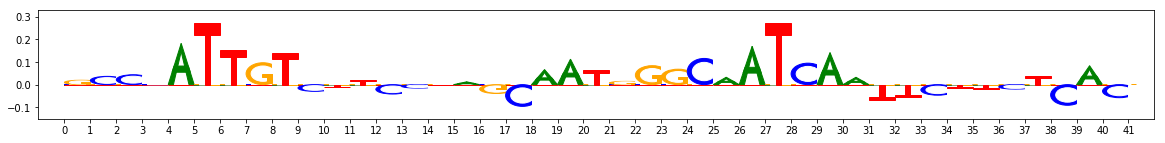

Neighbor rank 4 seqletidx 25


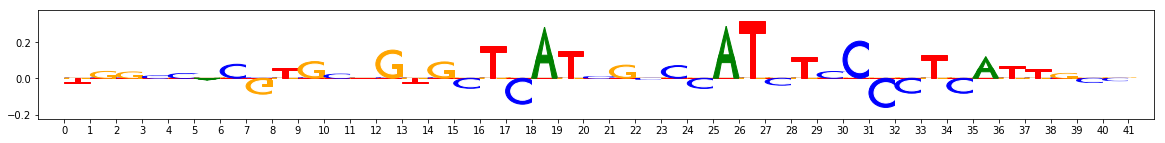

Neighbor rank 5 seqletidx 68


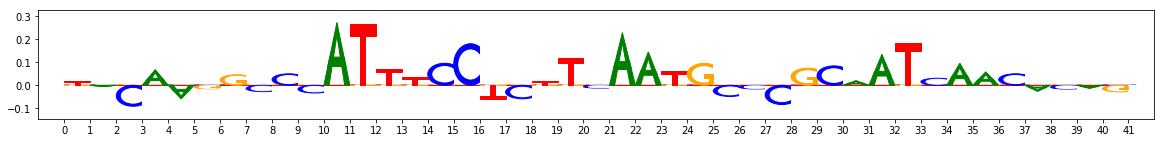

Neighbor rank 6 seqletidx 11


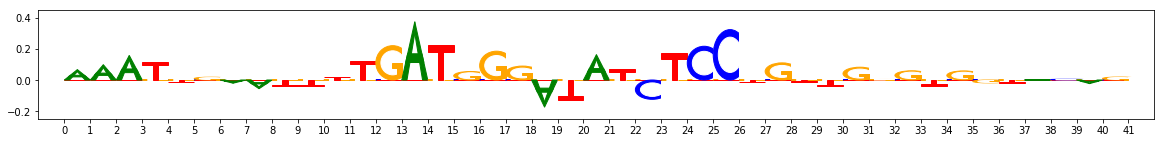

Neighbor rank 7 seqletidx 69


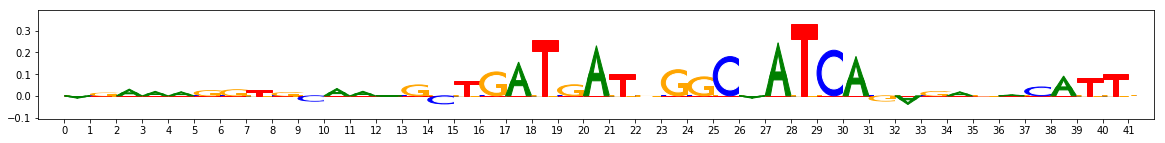

Neighbor rank 8 seqletidx 60


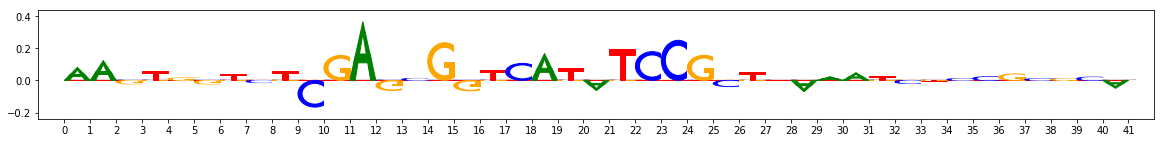

Neighbor rank 9 seqletidx 53


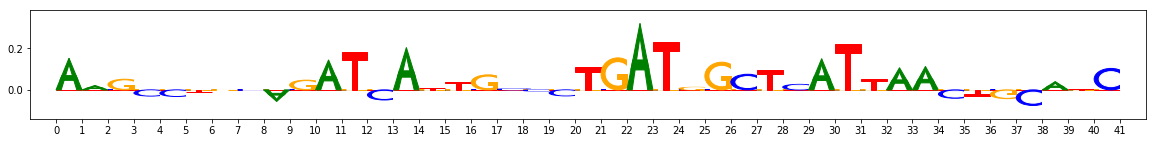

Neighbor rank 10 seqletidx 54


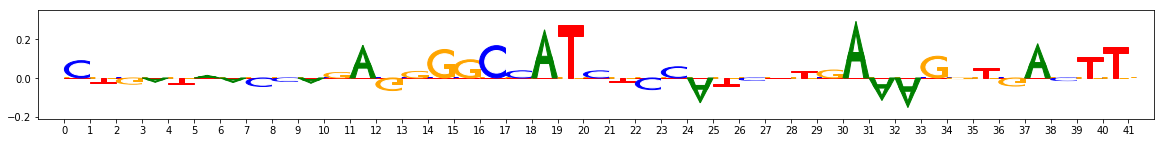

METHODNAME gkm_coarse_affmat ----------------------
original seqlet:


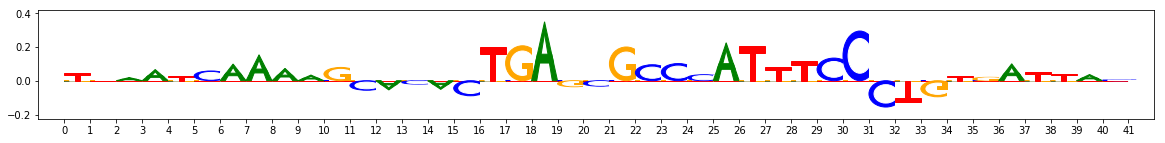

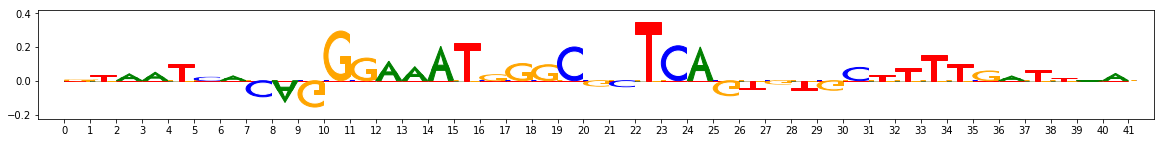

Neighbor rank 1 seqletidx 33


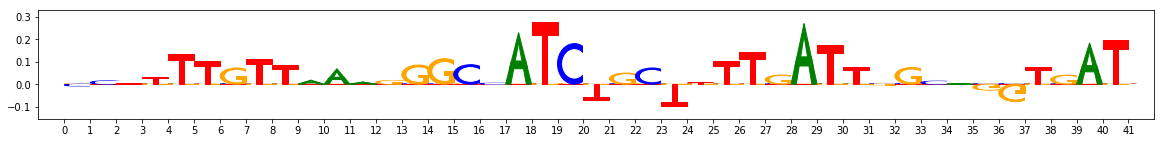

Neighbor rank 2 seqletidx 68


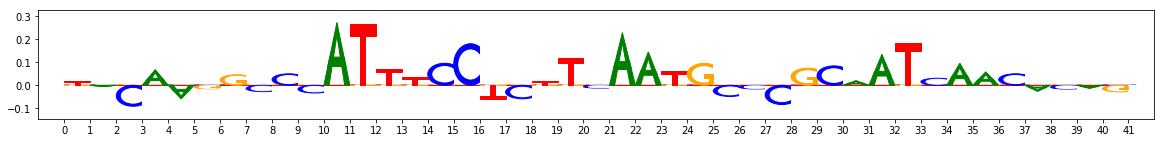

Neighbor rank 3 seqletidx 44


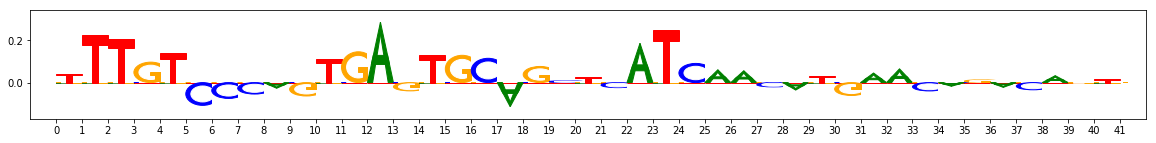

Neighbor rank 4 seqletidx 77


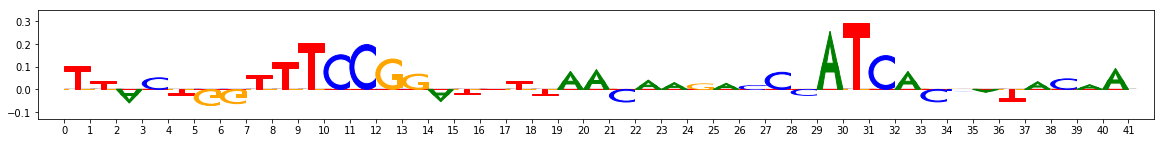

Neighbor rank 5 seqletidx 86


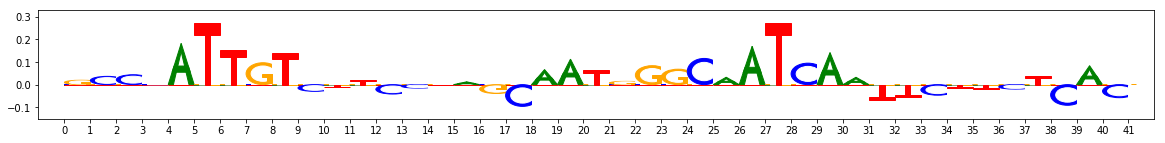

Neighbor rank 6 seqletidx 63


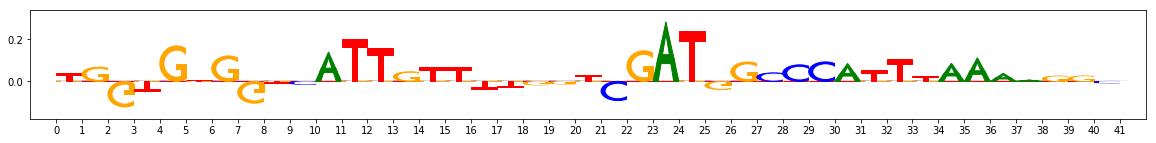

Neighbor rank 7 seqletidx 29


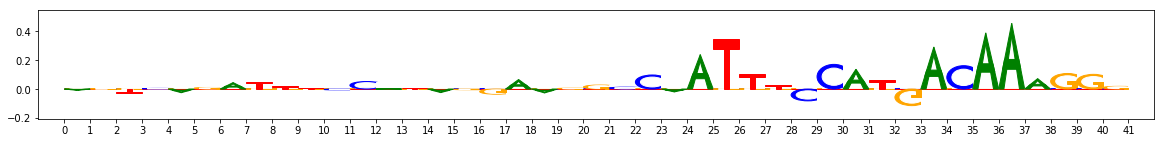

Neighbor rank 8 seqletidx 30


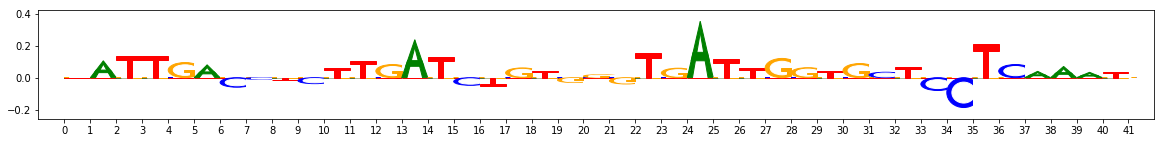

Neighbor rank 9 seqletidx 87


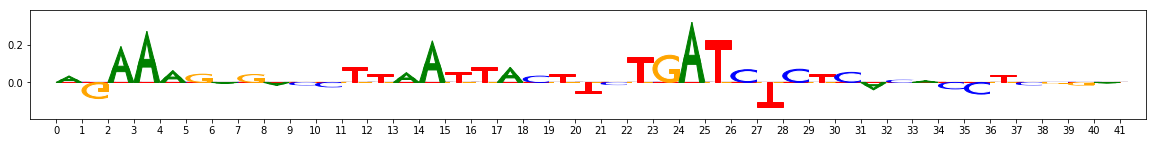

Neighbor rank 10 seqletidx 53


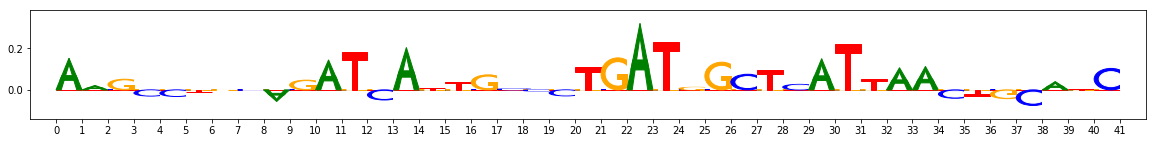

METHODNAME dlembedding_coarse_affmat ----------------------
original seqlet:


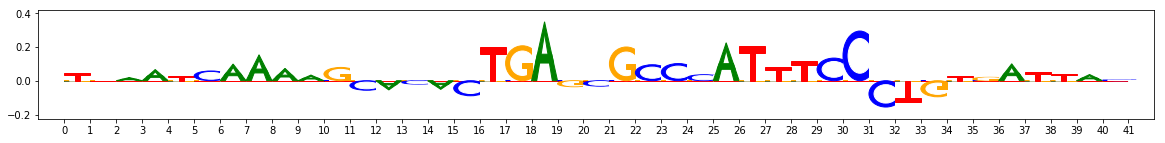

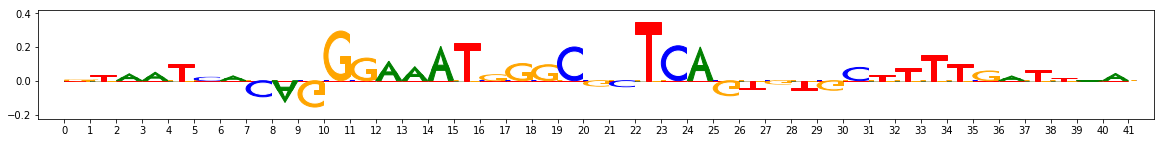

Neighbor rank 1 seqletidx 70


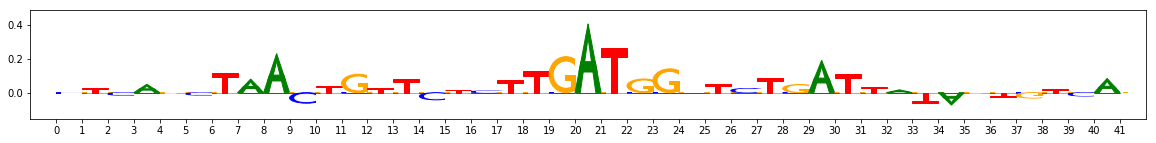

Neighbor rank 2 seqletidx 52


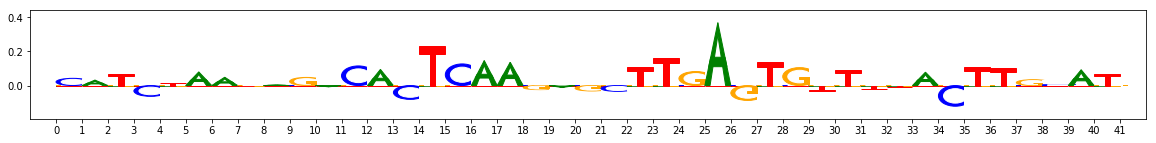

Neighbor rank 3 seqletidx 42


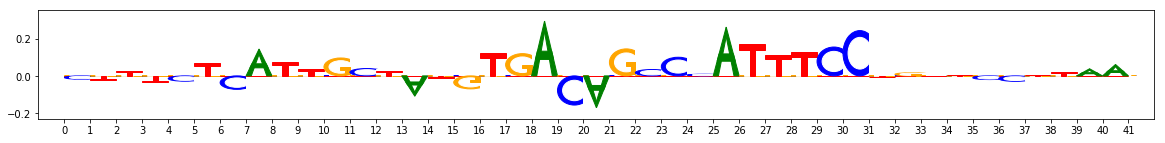

Neighbor rank 4 seqletidx 88


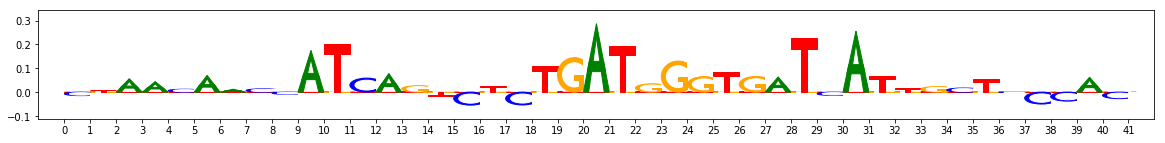

Neighbor rank 5 seqletidx 46


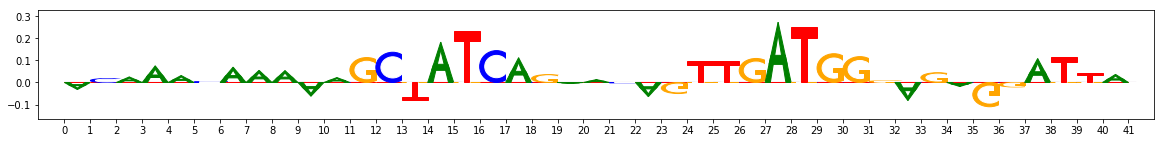

Neighbor rank 6 seqletidx 95


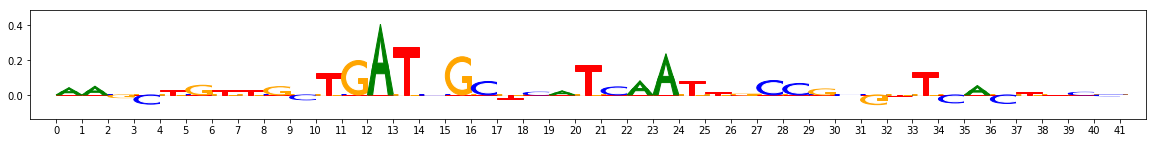

Neighbor rank 7 seqletidx 80


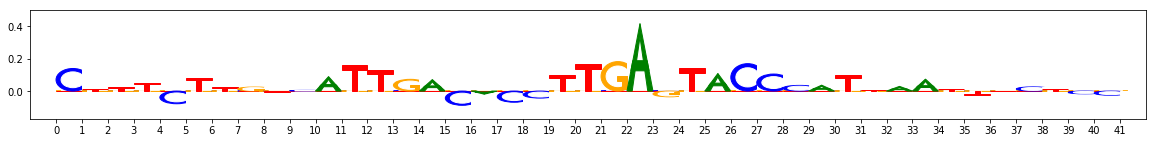

Neighbor rank 8 seqletidx 9


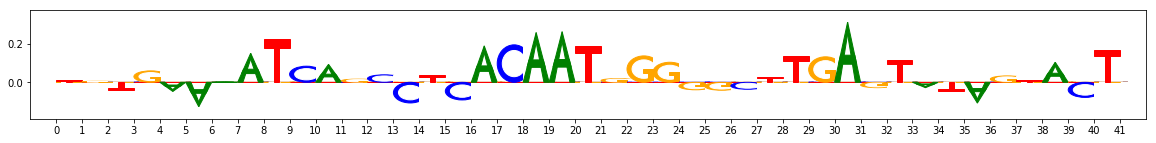

Neighbor rank 9 seqletidx 2


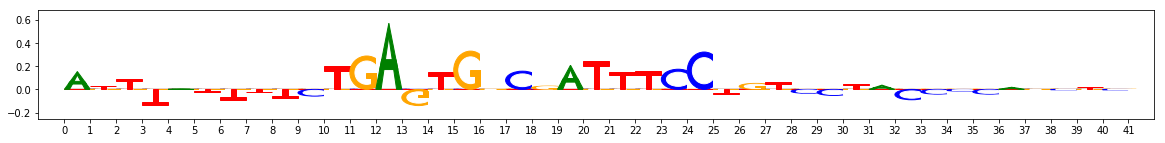

Neighbor rank 10 seqletidx 69


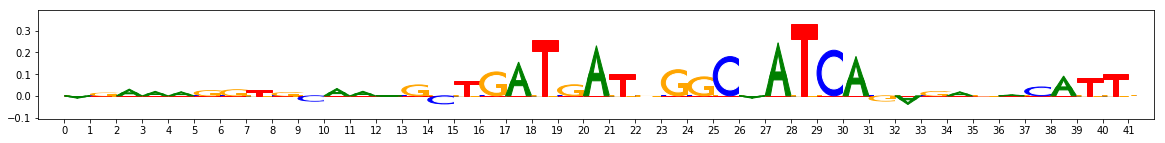

###########################
Seqlet idx 11
METHODNAME advanced_gapped_coarse_affmat ----------------------
original seqlet:


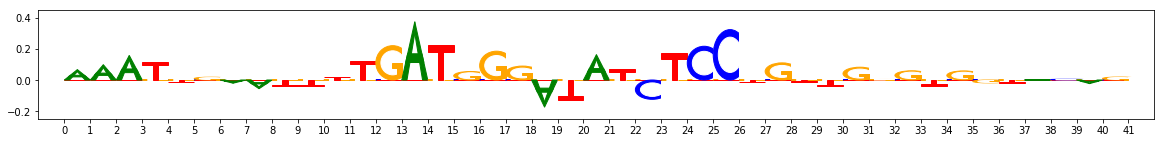

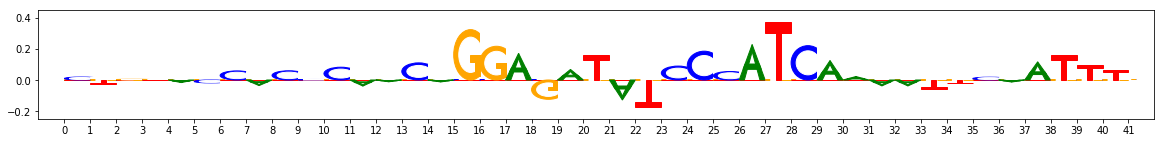

Neighbor rank 1 seqletidx 25


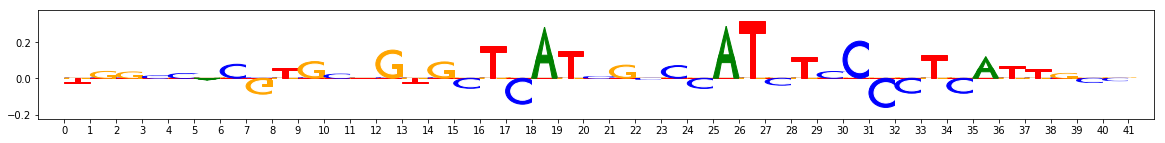

Neighbor rank 2 seqletidx 10


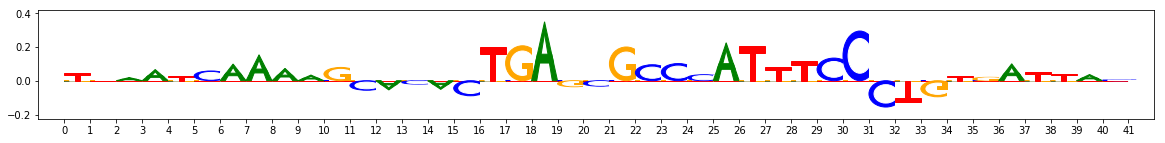

Neighbor rank 3 seqletidx 54


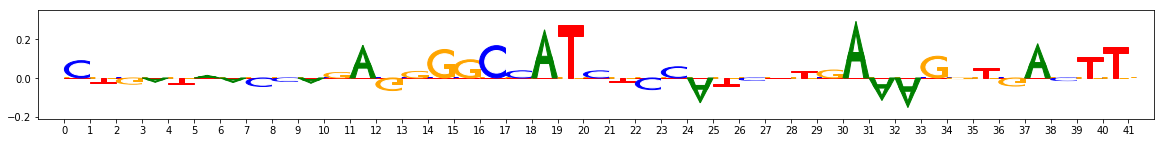

Neighbor rank 4 seqletidx 42


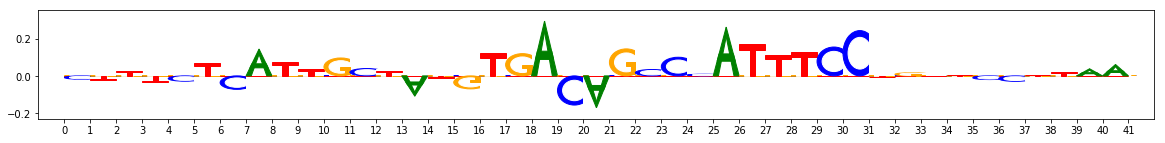

Neighbor rank 5 seqletidx 61


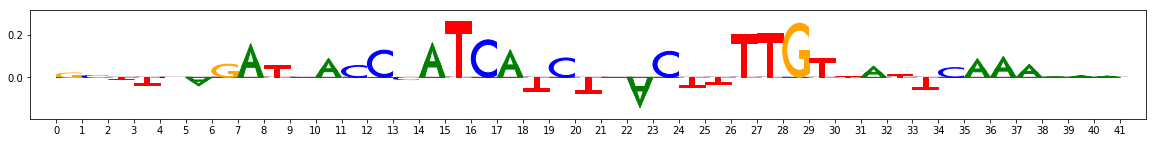

Neighbor rank 6 seqletidx 2


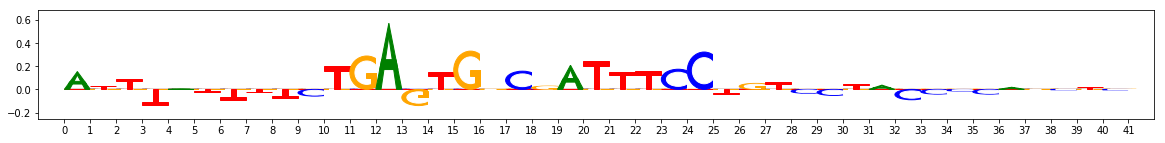

Neighbor rank 7 seqletidx 88


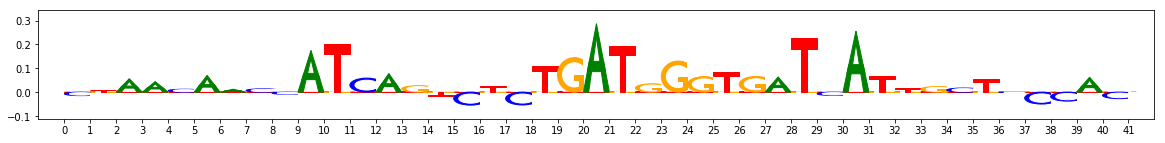

Neighbor rank 8 seqletidx 60


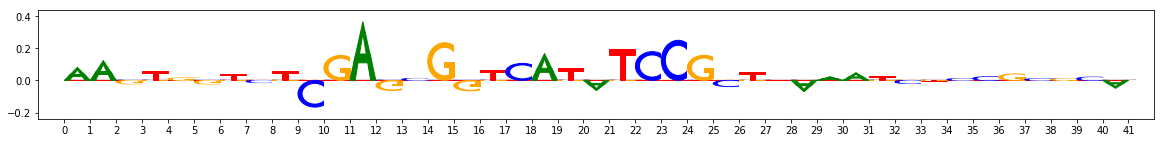

Neighbor rank 9 seqletidx 69


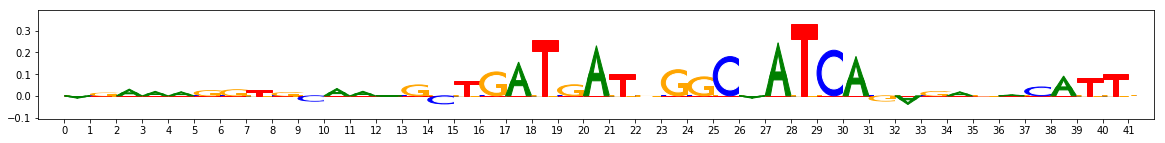

Neighbor rank 10 seqletidx 77


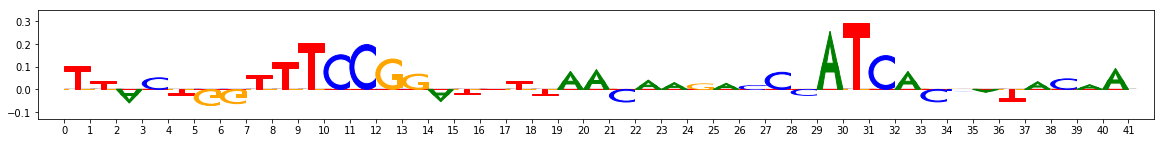

METHODNAME gkm_coarse_affmat ----------------------
original seqlet:


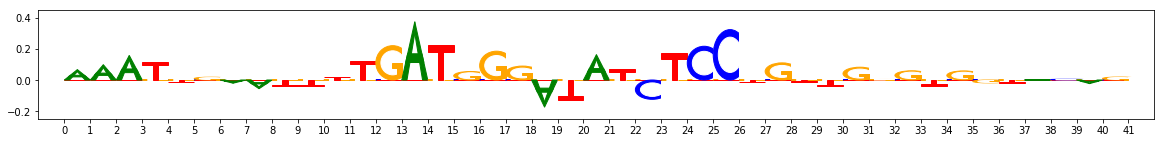

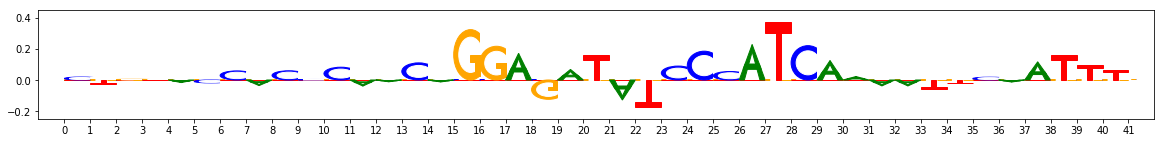

Neighbor rank 1 seqletidx 93


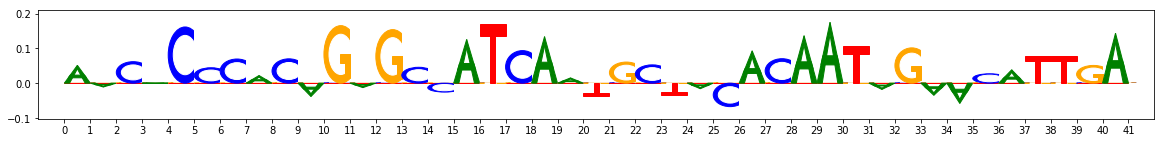

Neighbor rank 2 seqletidx 30


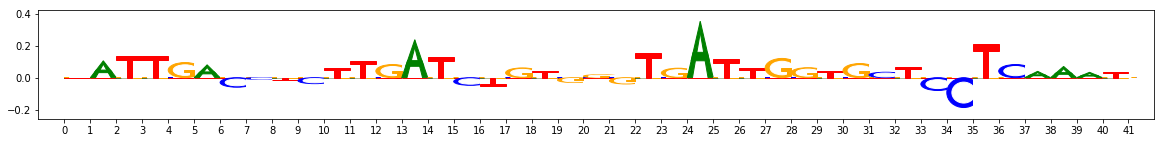

Neighbor rank 3 seqletidx 6


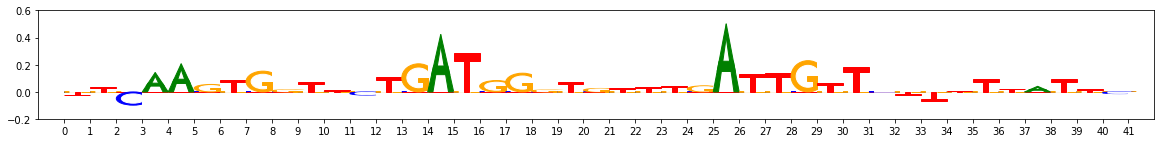

Neighbor rank 4 seqletidx 96


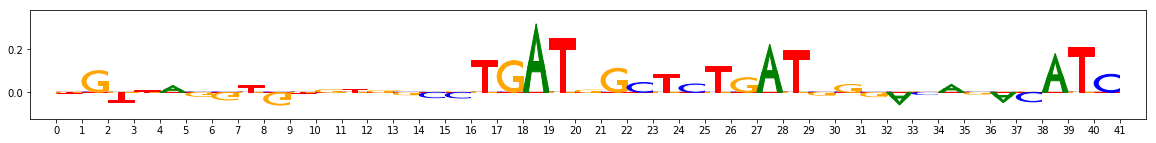

Neighbor rank 5 seqletidx 68


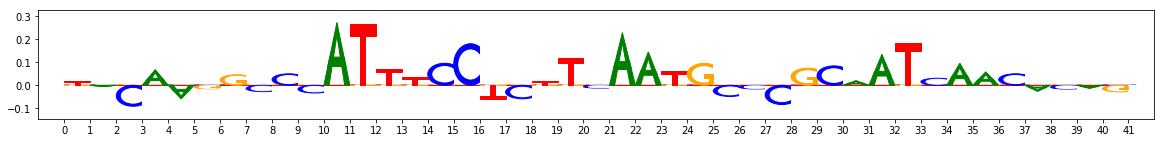

Neighbor rank 6 seqletidx 63


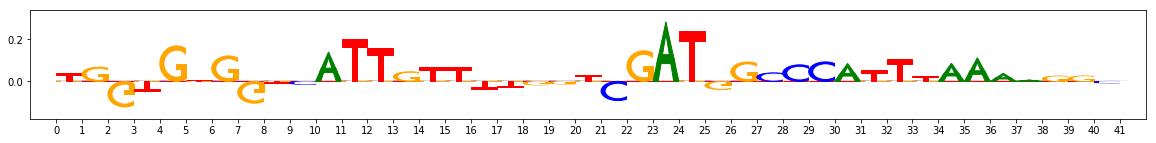

Neighbor rank 7 seqletidx 33


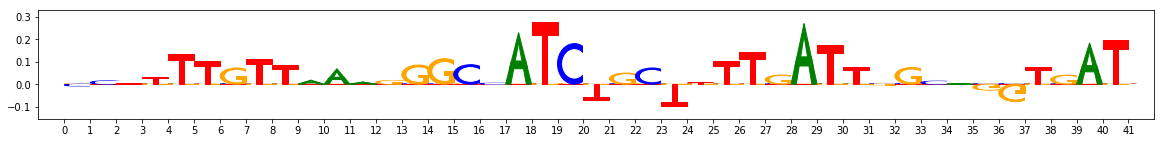

Neighbor rank 8 seqletidx 56


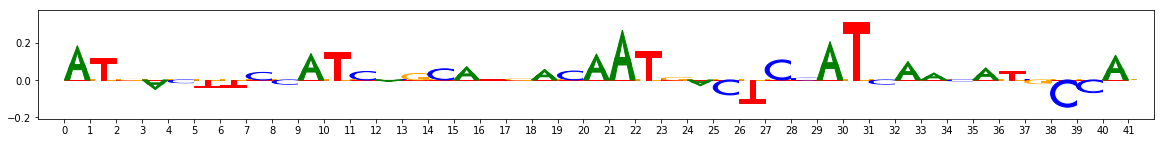

Neighbor rank 9 seqletidx 64


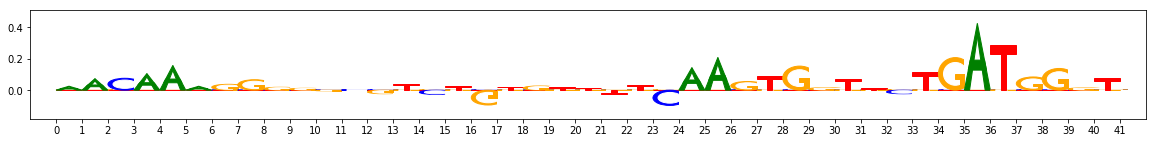

Neighbor rank 10 seqletidx 49


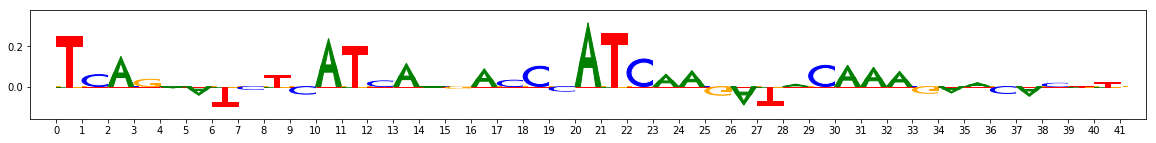

METHODNAME dlembedding_coarse_affmat ----------------------
original seqlet:


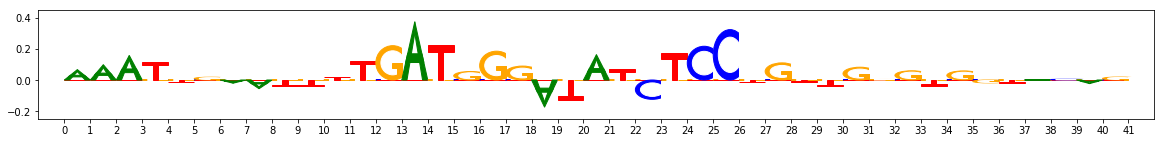

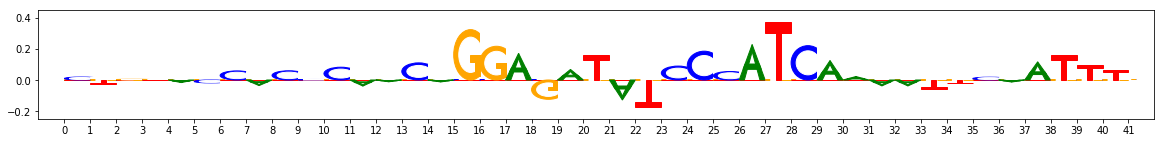

Neighbor rank 1 seqletidx 12


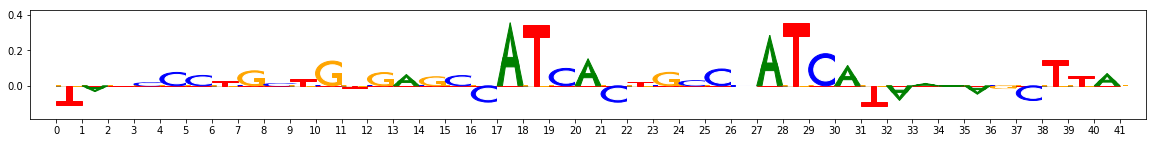

Neighbor rank 2 seqletidx 71


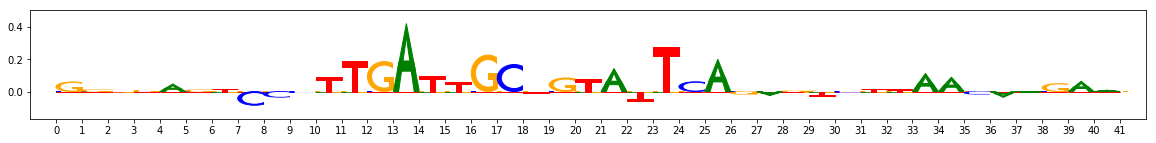

Neighbor rank 3 seqletidx 60


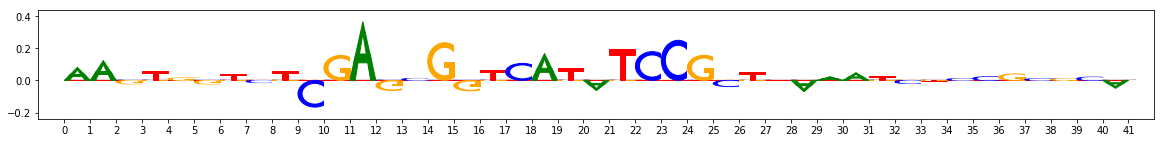

Neighbor rank 4 seqletidx 89


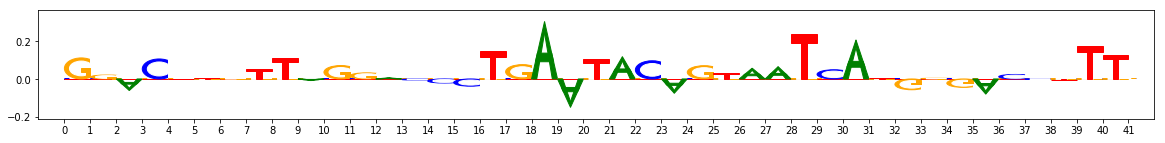

Neighbor rank 5 seqletidx 43


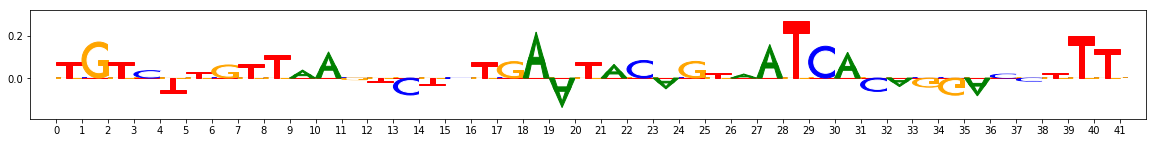

Neighbor rank 6 seqletidx 2


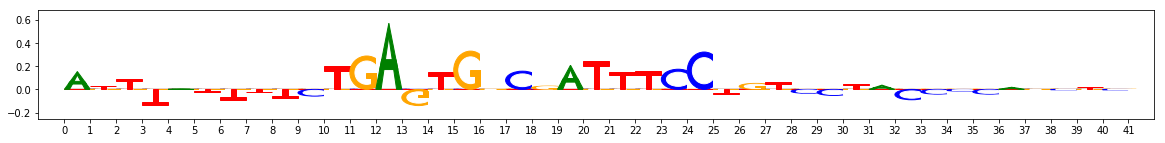

Neighbor rank 7 seqletidx 30


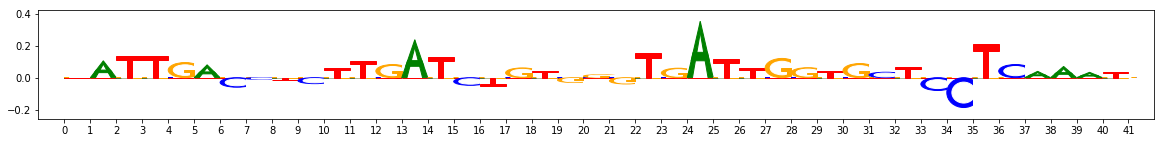

Neighbor rank 8 seqletidx 4


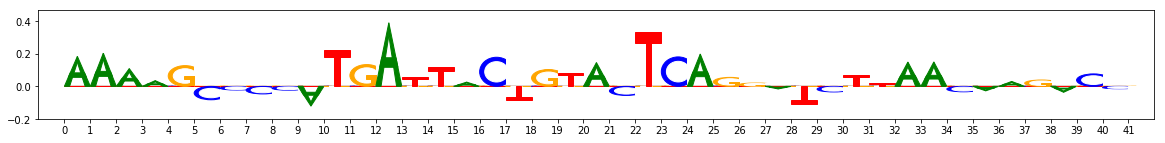

Neighbor rank 9 seqletidx 27


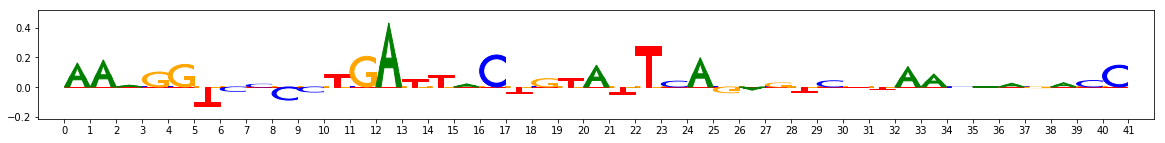

Neighbor rank 10 seqletidx 52


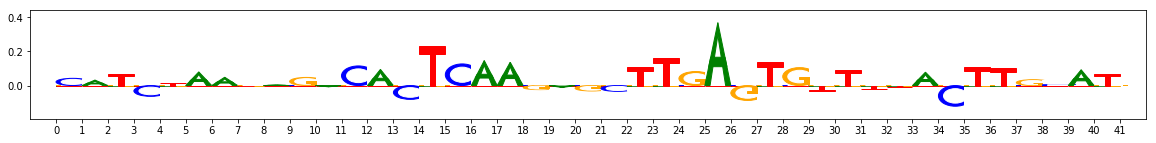

In [143]:


#10 - nanog-alt
#11 - nanog-alt with mismatch

for seqlet_idx in [10, 11]:
    print("###########################")
    print("Seqlet idx", seqlet_idx)
    for methodname, method_coarse_affmat in [
        ("advanced_gapped_coarse_affmat", subset_advanced_gapped_coarse_affmat),
        ("gkm_coarse_affmat", subset_gkm_coarse_affmat),
        ("dlembedding_coarse_affmat", subset_dlembedding_coarse_affmat)]:
        print("METHODNAME", methodname, "----------------------")
        
        print("original seqlet:")
        viz_sequence.plot_weights(seqlets[seqlet_idx]["Nanog_profile_wn_contrib_scores"].fwd)
        viz_sequence.plot_weights(seqlets[seqlet_idx]["Nanog_profile_wn_contrib_scores"].rev)
        
        top_neighbor_indices = np.argsort(-method_coarse_affmat[seqlet_idx])
        for neighborrank, neighboridx in enumerate(top_neighbor_indices[1:11]):
            print("Neighbor rank", neighborrank+1, "seqletidx", neighboridx)
            viz_sequence.plot_weights(seqlets[neighboridx]["Nanog_profile_wn_contrib_scores"].fwd)        